# Imports

In [1]:
class Object(object):
    pass

# We'll store all our variables here.
t = Object()

In [2]:
from PIL import Image, ImageDraw

Pytorch:

In [3]:
import torch
from torch import nn
import torchvision.transforms as transforms

Numpy and graphs:

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
import timeit
import datetime
import sys
import random
from typing import List, Tuple

We will keep variables inside an object to avoid pulluting the global namespace and prevent various bugs. The defition below allows adding attributes at runtime:

# Settings

You need to add the CelebA dataset to your Kaggle notebook.

In [5]:
t.image_root = "../../../../data/vae/img_align_celeba/"
t.image_folder = f"{t.image_root}/img_align_celeba"
t.output_folder = "../working"
t.crop_size = 178

For reproducibility, we will set a fixed seed for all randomized functions:

In [6]:
t.seed = 1
torch.manual_seed(t.seed)
torch.cuda.manual_seed(t.seed)
torch.cuda.manual_seed_all(t.seed)
np.random.seed(t.seed)
# For complete reproducibility
# torch.backends.cudnn.benchmark = False
# torch.backends.cudnn.deterministic = True

# Set Device

We can run our code on GPU or CPU, if GPU is not present. Training will be very slow on CPU. However, we can pre-train our model on GPU, save, and then experiment with it on CPU. That'll be reasonably fast.

In [7]:
t.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
t.device

device(type='cuda')

# Data Loader

We will no longer load all images into memory because it's not efficient, and the dataset is too large. We will use the Pytroch's Data Loader to load images efficiently.

The data loader concept uses two objects:

1. Data Set - represents the actual data, or, in our case, images.
2. Data Loader - specializes in loading, converting and passing the data to the model.

Let's start by defining the dataset.

In [8]:
import torchvision.datasets as datasets

def plot_images(images):
    fig, axis = plt.subplots(1, len(images), figsize=(20, 5))
    for i, im in enumerate(images):
        ax = axis[i]
        ax.axis('off')
        ax.imshow(im, cmap="gray")

# Load Image Metadata

Move images into subfolders for classes "with smile", "no smile" as ImageFolder expects. We will use these classes to transform images from "no smiles", to "smiles".

First, we read the 'smile' attribute from a CSV file that maps images to smile setting:

# Dataset

We will create a custom dataset object to return files in the order we want:

1. Return training subset
1. Use validation subset for validation
1. All faces will be labeled either smile or no smile

In [9]:
import csv

class ImageTensorDataset(torch.utils.data.Dataset):
    def __init__(self, csv_folder, image_folder, transform, is_train):
        self.folder = image_folder
        self.int_to_smile = {-1: "no_smile", 1: "smile"}
        self.smile_to_int = {
            self.int_to_smile[1]: 1,
            self.int_to_smile[-1]: -1
        }
        self.image_to_smile = {}
        self.smile_to_image = {"no_smile":[], "smile":[]}
        self.dataset_split = {"train": [], "valid":[], "test":[]}
        self.dataset_split_translation = {0: "train", 1: "valid", 2: "test"}
        self.load_metadata(csv_folder)
        self.set_type = "train" if is_train else "valid"
        self.transform = transform
        
    def load_metadata(self, csv_folder):
        for r in csv.DictReader(open(f"{csv_folder}/list_attr_celeba.csv")):
            self.image_to_smile[r['image_id']] = int(r['Smiling'])
            self.smile_to_image[self.int_to_smile[int(r['Smiling'])]].append(r['image_id'])
        for r in csv.DictReader(open(f"{csv_folder}/list_eval_partition.csv")):
            partition = int(r["partition"])
            translated_partition = self.dataset_split_translation[partition]
            self.dataset_split[translated_partition].append(r['image_id'])

    def __len__(self):
        return len(self.dataset_split[self.set_type])
    
    def __getitem__(self, index):
        files = self.dataset_split[self.set_type]
        file_id = files[index]
        file_path = self.folder + "/" + file_id
        im = self.transform(Image.open(file_path))
        return im, self.image_to_smile[file_id]

In [10]:
t.train_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.CenterCrop(t.crop_size), 
        transforms.Resize(128),
])


In [11]:
t.train_dataset = ImageTensorDataset(
    t.image_root, 
    t.image_folder, 
    t.train_transform, 
    is_train=True)

In [12]:
t.valid_dataset = ImageTensorDataset(
    t.image_root, 
    t.image_folder, 
    t.train_transform, 
    is_train=False
)

# Init Data Loader

In [13]:
t.train_loader = torch.utils.data.DataLoader(
    t.train_dataset,
    batch_size=32,
    num_workers=8,
    pin_memory=True,
)

In [14]:
t.valid_loader = torch.utils.data.DataLoader(
    t.valid_dataset,
    batch_size=512,
    num_workers=8,
    pin_memory=True,
)

Test loader is the same dataset, but 1024 samples, sampled from the beginning.

Read a small sample of images:

In [15]:
def read_images(train_loader, count):
    images = None
    remain = count
    for data in train_loader:
        batch_images, labels = data
        if images is None:
            images = batch_images[0:remain]
        else:
            images = torch.cat((images, batch_images), 0)
        remain -= min(remain, batch_images.size(0))
        if remain <= 0:
            break
    return images.to(t.device)

In [16]:
t.sample_images = read_images(t.train_loader, 10)
t.sample_images.shape

torch.Size([10, 3, 128, 128])

The function to display our images:

In [17]:
def plot_images_tensor(images_t):
    images = images_t.cpu().detach().permute(0, 2, 3, 1).numpy()
    fig, axis = plt.subplots(1, max(images.shape[0], 2), figsize=(20, 5))
    for i, im in enumerate(images):
        axis[i].axis('off')
        axis[i].imshow(im)
        
def plot_images(images):
    fig, axis = plt.subplots(1, len(images), figsize=(20, 5))
    for i, im in enumerate(images):
        ax = axis[i]
        ax.axis('off')
        ax.imshow(im, cmap="gray")

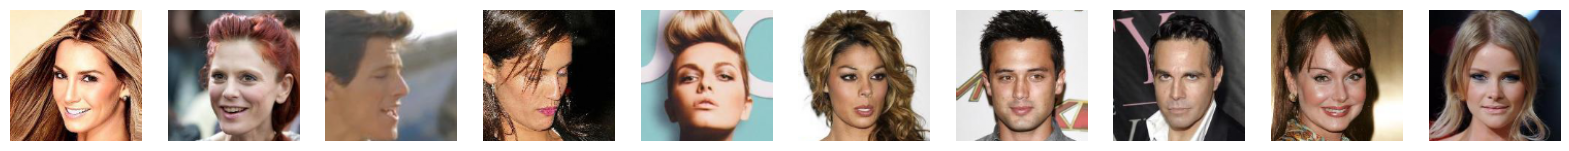

In [18]:
plot_images_tensor(t.sample_images)

Dataset maps folder names to class IDs. In our case, `0` will mean no smile, while `1` smile. This is very reasonable.

# Design Model

Pytorch doesn't provide a "reshape" layer that we will need for our model. They didn't provide "Flatten" for a while either, but then added it. The hope is they will add Reshape at some point as well.

For now, we'll just implement. All NN layers inherit from nn.Module.

In [19]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args
    def forward(self, x):
        return x.view(self.shape)

## Define Model

We now need to do extra steps during encoding, e.g. sampling from the normal distribution. So, we'll define our standard layers as `_encoder_main` and will have a function `encode` that will call layers, and do additional work.
    

In [20]:
import pytz 

class VAE(nn.Module):
    def __init__(self, device):
        super().__init__()
        
        self._total_epochs = 0
        self._training_time_s = 0
        self._timer = None

        self.N = torch.distributions.Normal(0, 1)
        if device.type == 'cuda':
            self.N.loc = self.N.loc.cuda()
            self.N.scale = self.N.scale.cuda()
        
        self.model_file_name = f"faces_vae_" \
            + datetime.datetime.now().astimezone(pytz.timezone('US/Pacific')).strftime("%Y-%m-%d_%H-%M") \
            + ".pkl"

        self.z_mean = torch.nn.Linear(64 * 8 * 8, 200)
        self.log_var = torch.nn.Linear(64 * 8 * 8, 200)

        self.encoder = nn.Sequential(
            # 128 x 128
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            # 64 x 64
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            # 32 x 32
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            # 16 x 16
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            
            nn.Flatten(),
        )
                
        self.decoder = nn.Sequential(
            nn.Linear(200, 64 * 8 * 8),
            Reshape(-1, 64, 8, 8),
            
            # 8 x 8 
            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            # 16 x 16
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # 32 x 32
            nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            # 64 x 64
            nn.ConvTranspose2d(32, 3, kernel_size=2, stride=2),  
#             nn.BatchNorm2d(32),
            nn.Sigmoid(),
            
            # 128 x 128
        )
        
        self.to(device)

    def encode(self, x):
        x = self.encoder(x)
        z_mean, log_var = self.z_mean(x), self.log_var(x)
        std_dev = torch.exp(0.5 * log_var)
        eps = self.N.sample(z_mean.shape)
        encoded = z_mean + eps * std_dev
        return encoded, z_mean, log_var

    def forward(self, x):
        encoded, z_mean, log_var = self.encode(x)
        decoded = self.decoder(encoded)
        return decoded, z_mean, log_var
    
    def start_training(self):
        if self._timer is None:
            self._timer = timeit.default_timer()

    def end_training(self):
        if self._timer:
            self._training_time_s += timeit.default_timer() - self._timer
            self._timer = None

    def add_epochs(self, epochs):
        self._total_epochs += epochs
        
    def training_timedelta(self):
        return datetime.timedelta(seconds=self._training_time_s)
    
t.model = VAE(t.device)

In [21]:
print('Parameters: ', sum(p.numel() for p in t.model.parameters()))

Parameters:  2557491


# Loss Function

## MSE Loss

In [22]:
t.mse_loss_base = nn.MSELoss(reduction="none")

def mse_loss(pred, y_true):
    pixel_loss = t.mse_loss_base(pred, y_true)
    batch_size = y_true.shape[0]
    pixel_loss_sum = pixel_loss.view(batch_size, -1).sum(axis=1) # sum over pixels
    loss = pixel_loss_sum.mean() # mean over batch
    return loss

## KL Divergence

In [23]:
def kl_div(z_mean, log_var):
    mu = z_mean
    var = torch.exp(log_var)
    kl_loss_sum = -0.5 * (1 + log_var - mu**2 - var).sum(axis=1) # sum over dimensions
    kl_loss = kl_loss_sum.mean() # mean over batch
    return kl_loss

## VAE Loss

In [24]:
def vae_loss(pred, y_true, kl_factor, z_mean, log_var):
    r_loss = mse_loss(pred, y_true)
    kl_loss = kl_div(z_mean, log_var)
    return r_loss + kl_factor * kl_loss, r_loss, kl_loss

# Analyze Images Before Training

### Inputs

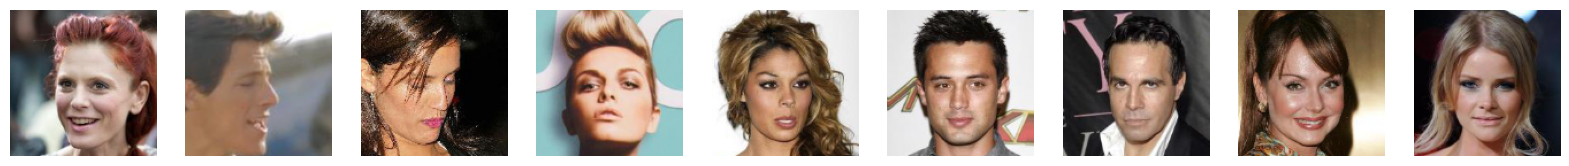

In [25]:
t.i = 1
plot_images_tensor(t.sample_images[t.i:t.i+10])

What would output, that is, decoded images will look like now, before we did no training of the network? Let's pass images through the network, that is, execute the sequence:

    Input Image -> Encoder -> (0.1, -2.3) -> Decoder -> Output Image
    
Let's run the end-to-end model, both encoder and decoder:

In [26]:
t.sample_output = t.model(t.sample_images[t.i : t.i+10])[0]

What is the output?

In [27]:
t.sample_output.shape

torch.Size([9, 3, 128, 128])

Display output images

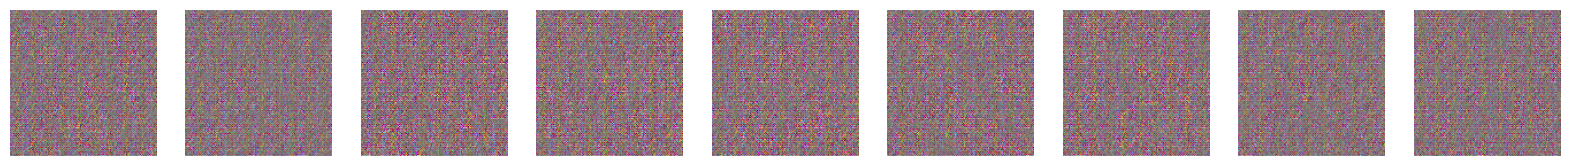

In [28]:
plot_images_tensor(t.sample_output)

# Training Loop

We need to modify our train loop to read images from the data loader and not from memory. Images will no longer fit into memory (at least on Kaggle).

We will do an optimization to speed up our calculation. Instead of reloading images and sending them to GPU again and again, we will pre-allocate memory on GPU, copy images once, then use them directly.

In [29]:
def calculate_validation_loss(model, valid_loader, criterion, device, kl_factor):
    model.eval()
    total_loss = 0
    mse_loss = 0
    kl_loss = 0
    image_count = 0
    
    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            output, z_mean, log_var = model(images)
            cur_loss, cur_r_loss, cur_kl_loss = criterion(output, images, kl_factor, z_mean, log_var)
 
            batch_size = images.shape[0] # Can have an incomlete batch at the end
            del images # to help free memory on GPU

            total_loss += cur_loss * batch_size  # recover sum from the mean return by the loss function.
            mse_loss += cur_r_loss * batch_size  # we'll need it to correctly calcualte the global mean.
            kl_loss += cur_kl_loss * batch_size
            
            image_count += batch_size
            
    return total_loss / image_count, mse_loss / image_count, kl_loss / image_count

In [30]:
def image_count(image_folder):
    result = 0
    for _ in os.listdir(image_folder):
        result += 1
    return result

t.image_count = image_count(t.image_folder)
t.image_count

202599

In [31]:
import time
from datetime import timedelta

def train(model, n_epochs, train_loader, opt, report_each_nth_batch, start_lr,
         valid_loader):
    print("Running on: ", t.device)
    print("Model name:", model.model_file_name)
    print("Model parameters:", sum(p.numel() for p in t.model.parameters()))
    print()
    print(f"Batch size: {train_loader.batch_size}, Epochs: {n_epochs}")
    print("Epoch, Batch num, Train loss, Valid Loss, MSE loss, KL loss, KL Factor, Total epochs, Train time, Total train time, LR")

    log_dict = {
        'batch_train_loss': [], 
        'batch_mse_loss': [], 
        'batch_kl_div': [], 
        'valid_loss': []
    }
    
    start_time = time.time()
    batch_num = 0
    kl_factor = 1
    epoch = 0 
    train_loss = -1
    
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        opt, 
        mode='min',
        factor=0.1, 
        patience=3, 
        threshold=1, 
        threshold_mode='abs') 
    
    while model._total_epochs < n_epochs:
        epoch += 1
        # Start of epoch training
        for i, data in enumerate(train_loader):
            image_batch, labels_smile = data
            model.start_training()

            image_batch = image_batch.to(t.device, non_blocking=True)
            
            # Train model
            output, z_mean, log_var = model(image_batch)
            loss, r_loss, kl_div = vae_loss(output, image_batch, kl_factor, z_mean, log_var)
            
            log_dict['batch_train_loss'].append(loss.item())
            log_dict['batch_mse_loss'].append(r_loss.item())
            log_dict['batch_kl_div'].append(kl_div.item())
                    
            model.zero_grad()
            
            loss.backward()
            
            opt.step()
            
            batch_num += 1
            
            if batch_num % report_each_nth_batch == 0:
                with torch.no_grad():
                    model.eval()
                    train_loss = loss.item()
                    # Validate
                    total, r_loss, kl_div = calculate_validation_loss(model, valid_loader, vae_loss, t.device, kl_factor)
                    model.end_training()
                    print(f"{epoch}, {batch_num}, {train_loss:.2f}, {total.item():.2f}, {r_loss.item():.2f},", 
                          f"{kl_div.item():.2f}, {kl_factor}, {model._total_epochs},",
                          f"{timedelta(seconds=time.time() - start_time)},",
                          f"{model.training_timedelta()}, {start_lr}")
                    model.train()
                    model.start_training()
        # End of epoch training        
        lr_scheduler.step(loss)
        model.add_epochs(1)
        torch.save(t.model, model.model_file_name)
    model.end_training()
    model.eval()
    # Validate
    with torch.no_grad():
        total, r_loss, kl_div = calculate_validation_loss(model, valid_loader, vae_loss, t.device, kl_factor)
        print(f"{epoch}, {batch_num}, {train_loss:.2f}, {total.item():.2f}, {r_loss.item():.2f},", 
              f"{kl_div.item():.2f},",
              f"{model._total_epochs}, {timedelta(seconds=time.time() - start_time)},",
              f"{model.training_timedelta()},",
              f"{start_lr}")
    return log_dict

# Run Training

In [32]:
%%time

t.opt = torch.optim.Adam(t.model.parameters(), lr=1e-4)

log_dict = train(
    model = t.model, 
    n_epochs = 200, 
    train_loader  = t.train_loader, 
    opt = t.opt, 
    report_each_nth_batch = 2000,
    start_lr = 1e-4,
    valid_loader=t.valid_loader
)

Running on:  cuda
Model name: faces_vae_2022-12-10_17-35.pkl
Model parameters: 2557491

Batch size: 32, Epochs: 200
Epoch, Batch num, Train loss, Valid Loss, MSE loss, KL loss, KL Factor, Total epochs, Train time, Total train time, LR


1, 2000, 847.24, 884.73, 689.80, 194.93, 1, 0, 0:00:38.080253, 0:00:37.716638, 0.0001


1, 4000, 789.53, 806.24, 609.37, 196.87, 1, 0, 0:01:15.597081, 0:01:15.232673, 0.0001


2, 6000, 826.81, 728.75, 538.23, 190.52, 1, 1, 0:01:53.668328, 0:01:53.303137, 0.0001


2, 8000, 698.45, 687.84, 508.43, 179.41, 1, 1, 0:02:31.204448, 0:02:30.838438, 0.0001


2, 10000, 647.81, 668.40, 497.06, 171.34, 1, 1, 0:03:09.059195, 0:03:08.692413, 0.0001


3, 12000, 630.48, 657.01, 482.18, 174.83, 1, 2, 0:03:47.243501, 0:03:46.875976, 0.0001


3, 14000, 667.50, 640.62, 464.57, 176.05, 1, 2, 0:04:25.064677, 0:04:24.696609, 0.0001


4, 16000, 638.08, 630.87, 460.96, 169.92, 1, 3, 0:05:03.132473, 0:05:02.763905, 0.0001


4, 18000, 631.55, 626.30, 452.91, 173.40, 1, 3, 0:05:40.937675, 0:05:40.568381, 0.0001


4, 20000, 620.65, 619.89, 452.28, 167.61, 1, 3, 0:06:18.933842, 0:06:18.564116, 0.0001


5, 22000, 656.40, 610.15, 440.81, 169.34, 1, 4, 0:06:57.220017, 0:06:56.849730, 0.0001


5, 24000, 577.46, 608.49, 437.37, 171.12, 1, 4, 0:07:35.184424, 0:07:34.813350, 0.0001


6, 26000, 559.90, 601.39, 433.76, 167.63, 1, 5, 0:08:13.698942, 0:08:13.327309, 0.0001


6, 28000, 597.77, 599.12, 429.24, 169.88, 1, 5, 0:08:51.601857, 0:08:51.229789, 0.0001


6, 30000, 592.72, 594.19, 426.43, 167.76, 1, 5, 0:09:29.322931, 0:09:28.950443, 0.0001


7, 32000, 574.49, 594.51, 425.37, 169.14, 1, 6, 0:10:07.501755, 0:10:07.128759, 0.0001


7, 34000, 582.90, 591.33, 421.88, 169.46, 1, 6, 0:10:45.183336, 0:10:44.809781, 0.0001


8, 36000, 642.61, 588.62, 421.77, 166.85, 1, 7, 0:11:23.227692, 0:11:22.853674, 0.0001


8, 38000, 576.15, 586.90, 417.55, 169.35, 1, 7, 0:12:01.034831, 0:12:00.660387, 0.0001


8, 40000, 560.71, 585.29, 419.73, 165.55, 1, 7, 0:12:38.826883, 0:12:38.452017, 0.0001


9, 42000, 555.84, 585.69, 420.27, 165.42, 1, 8, 0:13:17.010203, 0:13:16.634906, 0.0001


9, 44000, 562.37, 582.26, 412.73, 169.53, 1, 8, 0:13:55.035308, 0:13:54.659566, 0.0001


10, 46000, 573.76, 578.39, 411.94, 166.44, 1, 9, 0:14:33.080110, 0:14:32.703955, 0.0001


10, 48000, 557.62, 580.19, 411.82, 168.36, 1, 9, 0:15:10.702879, 0:15:10.326295, 0.0001


10, 50000, 606.83, 576.26, 409.16, 167.10, 1, 9, 0:15:48.701961, 0:15:48.324966, 0.0001


11, 52000, 639.40, 574.92, 409.37, 165.55, 1, 10, 0:16:26.831371, 0:16:26.453880, 0.0001


11, 54000, 611.88, 577.53, 412.16, 165.37, 1, 10, 0:17:04.626397, 0:17:04.248157, 0.0001


12, 56000, 581.41, 574.56, 406.76, 167.79, 1, 11, 0:17:42.901853, 0:17:42.523075, 0.0001


12, 58000, 577.81, 570.60, 402.47, 168.13, 1, 11, 0:18:20.681931, 0:18:20.302688, 0.0001


12, 60000, 561.08, 572.02, 403.66, 168.36, 1, 11, 0:18:58.522979, 0:18:58.143319, 0.0001


13, 62000, 591.42, 567.34, 397.25, 170.09, 1, 12, 0:19:36.870497, 0:19:36.490426, 0.0001


13, 64000, 684.51, 565.55, 396.20, 169.35, 1, 12, 0:20:14.730814, 0:20:14.350232, 0.0001


13, 66000, 595.25, 566.15, 400.34, 165.82, 1, 12, 0:20:52.660985, 0:20:52.279621, 0.0001


14, 68000, 594.92, 563.36, 395.43, 167.93, 1, 13, 0:21:30.528871, 0:21:30.146780, 0.0001


14, 70000, 564.94, 562.87, 395.26, 167.61, 1, 13, 0:22:08.078779, 0:22:07.696147, 0.0001


15, 72000, 578.01, 561.53, 392.56, 168.96, 1, 14, 0:22:46.188663, 0:22:45.805225, 0.0001


15, 74000, 542.32, 558.40, 390.36, 168.04, 1, 14, 0:23:23.937983, 0:23:23.553799, 0.0001


15, 76000, 619.11, 559.36, 391.86, 167.50, 1, 14, 0:24:01.573793, 0:24:01.189181, 0.0001


16, 78000, 568.32, 558.30, 389.72, 168.58, 1, 15, 0:24:39.693851, 0:24:39.308809, 0.0001


16, 80000, 598.56, 559.68, 389.66, 170.02, 1, 15, 0:25:17.354465, 0:25:16.969001, 0.0001


17, 82000, 566.48, 555.68, 386.15, 169.52, 1, 16, 0:25:55.618327, 0:25:55.232359, 0.0001


17, 84000, 519.65, 558.11, 390.72, 167.39, 1, 16, 0:26:33.331071, 0:26:32.944320, 0.0001


17, 86000, 574.68, 553.56, 381.76, 171.80, 1, 16, 0:27:11.076753, 0:27:10.689215, 0.0001


18, 88000, 568.95, 561.44, 392.58, 168.87, 1, 17, 0:27:49.340550, 0:27:48.952287, 0.0001


18, 90000, 557.95, 551.89, 382.82, 169.07, 1, 17, 0:28:27.335285, 0:28:26.946514, 0.0001


19, 92000, 542.61, 553.15, 386.17, 166.99, 1, 18, 0:29:05.482645, 0:29:05.093063, 0.0001


19, 94000, 571.80, 551.18, 379.76, 171.42, 1, 18, 0:29:43.236034, 0:29:42.845640, 0.0001


19, 96000, 537.57, 550.73, 382.45, 168.28, 1, 18, 0:30:20.938443, 0:30:20.547258, 0.0001


20, 98000, 526.52, 550.73, 382.75, 167.98, 1, 19, 0:30:58.881717, 0:30:58.489771, 0.0001


20, 100000, 533.45, 550.00, 380.28, 169.72, 1, 19, 0:31:36.801150, 0:31:36.408695, 0.0001


21, 102000, 515.66, 551.42, 383.05, 168.37, 1, 20, 0:32:14.902790, 0:32:14.509532, 0.0001


21, 104000, 557.69, 548.65, 378.29, 170.36, 1, 20, 0:32:52.610356, 0:32:52.216379, 0.0001


21, 106000, 589.93, 547.81, 379.85, 167.96, 1, 20, 0:33:30.370679, 0:33:29.976277, 0.0001


22, 108000, 559.38, 548.84, 380.94, 167.90, 1, 21, 0:34:08.574820, 0:34:08.180007, 0.0001


22, 110000, 539.16, 546.18, 379.27, 166.91, 1, 21, 0:34:46.462756, 0:34:46.067528, 0.0001


23, 112000, 587.92, 551.34, 382.68, 168.67, 1, 22, 0:35:24.624145, 0:35:24.228402, 0.0001


23, 114000, 629.86, 549.58, 382.57, 167.01, 1, 22, 0:36:02.403995, 0:36:02.007421, 0.0001


23, 116000, 607.48, 546.84, 375.02, 171.82, 1, 22, 0:36:39.943164, 0:36:39.545653, 0.0001


24, 118000, 571.71, 545.37, 376.46, 168.91, 1, 23, 0:37:17.944709, 0:37:17.546680, 0.0001


24, 120000, 553.31, 544.97, 375.04, 169.93, 1, 23, 0:37:55.744482, 0:37:55.345644, 0.0001


24, 122000, 564.00, 545.65, 376.51, 169.14, 1, 23, 0:38:33.659098, 0:38:33.259471, 0.0001


25, 124000, 591.77, 545.70, 375.81, 169.89, 1, 24, 0:39:11.991758, 0:39:11.591334, 0.0001


25, 126000, 549.79, 546.52, 375.81, 170.71, 1, 24, 0:39:49.875058, 0:39:49.473842, 0.0001


26, 128000, 586.46, 545.87, 379.77, 166.10, 1, 25, 0:40:28.421926, 0:40:28.020075, 0.0001


26, 130000, 531.51, 547.24, 376.98, 170.26, 1, 25, 0:41:06.235074, 0:41:05.832797, 0.0001


26, 132000, 566.85, 542.59, 372.28, 170.32, 1, 25, 0:41:44.321046, 0:41:43.918278, 0.0001


27, 134000, 555.82, 544.12, 376.63, 167.50, 1, 26, 0:42:22.424687, 0:42:22.021096, 0.0001


27, 136000, 546.09, 544.52, 375.46, 169.06, 1, 26, 0:43:00.320465, 0:42:59.916058, 0.0001


28, 138000, 596.79, 541.19, 371.15, 170.04, 1, 27, 0:43:38.475557, 0:43:38.070347, 0.0001


28, 140000, 579.86, 540.81, 368.79, 172.01, 1, 27, 0:44:16.319774, 0:44:15.913744, 0.0001


28, 142000, 584.18, 542.48, 373.51, 168.97, 1, 27, 0:44:54.222277, 0:44:53.815448, 0.0001


29, 144000, 542.13, 541.99, 372.30, 169.70, 1, 28, 0:45:32.522800, 0:45:32.115255, 0.0001


29, 146000, 521.14, 540.68, 372.21, 168.47, 1, 28, 0:46:10.324122, 0:46:09.916070, 0.0001


30, 148000, 519.40, 539.36, 370.16, 169.20, 1, 29, 0:46:48.514940, 0:46:48.106167, 0.0001


30, 150000, 550.90, 542.48, 374.48, 168.01, 1, 29, 0:47:26.100045, 0:47:25.690768, 0.0001


30, 152000, 542.58, 540.24, 373.19, 167.05, 1, 29, 0:48:03.890926, 0:48:03.480934, 0.0001


31, 154000, 498.22, 539.84, 369.71, 170.13, 1, 30, 0:48:41.977219, 0:48:41.566717, 0.0001


31, 156000, 585.53, 538.54, 371.21, 167.33, 1, 30, 0:49:19.435209, 0:49:19.023951, 0.0001


32, 158000, 588.10, 540.68, 372.72, 167.96, 1, 31, 0:49:57.544347, 0:49:57.132649, 0.0001


32, 160000, 487.62, 537.97, 371.56, 166.41, 1, 31, 0:50:35.174601, 0:50:34.762387, 0.0001


32, 162000, 535.30, 538.05, 369.41, 168.64, 1, 31, 0:51:12.991815, 0:51:12.579062, 0.0001


33, 164000, 558.30, 538.97, 369.72, 169.25, 1, 32, 0:51:51.141009, 0:51:50.727508, 0.0001


33, 166000, 506.58, 537.93, 368.78, 169.15, 1, 32, 0:52:28.798919, 0:52:28.384986, 0.0001


34, 168000, 523.68, 538.37, 368.44, 169.93, 1, 33, 0:53:06.851089, 0:53:06.436746, 0.0001


34, 170000, 583.08, 537.17, 370.25, 166.92, 1, 33, 0:53:44.327873, 0:53:43.913080, 0.0001


34, 172000, 535.06, 537.73, 368.06, 169.67, 1, 33, 0:54:22.146565, 0:54:21.731285, 0.0001


35, 174000, 514.21, 535.79, 367.22, 168.57, 1, 34, 0:55:00.306177, 0:54:59.890192, 0.0001


35, 176000, 549.85, 535.90, 367.48, 168.42, 1, 34, 0:55:37.904241, 0:55:37.487819, 0.0001


35, 178000, 513.55, 536.30, 368.93, 167.37, 1, 34, 0:56:15.765969, 0:56:15.348968, 0.0001


36, 180000, 529.43, 535.24, 366.15, 169.09, 1, 35, 0:56:53.760261, 0:56:53.342534, 0.0001


36, 182000, 559.00, 537.13, 369.24, 167.89, 1, 35, 0:57:31.247085, 0:57:30.828910, 0.0001


37, 184000, 550.00, 535.22, 366.62, 168.60, 1, 36, 0:58:09.488715, 0:58:09.070047, 0.0001


37, 186000, 549.31, 537.68, 369.69, 167.99, 1, 36, 0:58:47.322216, 0:58:46.902799, 0.0001


37, 188000, 547.15, 536.80, 368.17, 168.63, 1, 36, 0:59:25.060457, 0:59:24.640553, 0.0001


38, 190000, 567.79, 537.36, 368.22, 169.14, 1, 37, 1:00:02.915996, 1:00:02.495289, 0.0001


38, 192000, 544.47, 535.03, 366.24, 168.79, 1, 37, 1:00:40.617056, 1:00:40.195603, 0.0001


39, 194000, 560.38, 535.83, 367.91, 167.92, 1, 38, 1:01:18.742521, 1:01:18.320578, 0.0001


39, 196000, 528.99, 533.64, 364.96, 168.68, 1, 38, 1:01:56.480738, 1:01:56.058016, 0.0001


39, 198000, 480.85, 535.65, 369.19, 166.46, 1, 38, 1:02:34.161813, 1:02:33.738493, 0.0001


40, 200000, 526.47, 534.37, 368.20, 166.17, 1, 39, 1:03:12.272250, 1:03:11.848420, 0.0001


40, 202000, 558.00, 533.70, 366.96, 166.74, 1, 39, 1:03:50.167947, 1:03:49.743309, 0.0001


41, 204000, 523.05, 534.12, 365.30, 168.82, 1, 40, 1:04:28.460205, 1:04:28.034867, 0.0001


41, 206000, 494.02, 534.18, 365.16, 169.02, 1, 40, 1:05:05.972578, 1:05:05.546737, 0.0001


41, 208000, 490.66, 535.87, 364.90, 170.96, 1, 40, 1:05:44.014210, 1:05:43.587649, 0.0001


42, 210000, 536.65, 533.45, 365.80, 167.66, 1, 41, 1:06:22.195419, 1:06:21.768352, 0.0001


42, 212000, 513.17, 534.34, 365.35, 169.00, 1, 41, 1:06:59.968266, 1:06:59.540393, 0.0001


43, 214000, 539.96, 533.03, 362.89, 170.14, 1, 42, 1:07:38.473153, 1:07:38.044515, 0.0001


43, 216000, 548.42, 534.01, 367.59, 166.42, 1, 42, 1:08:16.344590, 1:08:15.915098, 0.0001


43, 218000, 533.30, 532.51, 363.27, 169.24, 1, 42, 1:08:54.232431, 1:08:53.802139, 0.0001


44, 220000, 496.43, 531.37, 364.64, 166.73, 1, 43, 1:09:32.405447, 1:09:31.974413, 0.0001


44, 222000, 484.83, 533.51, 362.13, 171.37, 1, 43, 1:10:10.296172, 1:10:09.864528, 0.0001


45, 224000, 500.72, 531.71, 363.73, 167.99, 1, 44, 1:10:48.598920, 1:10:48.166665, 0.0001


45, 226000, 581.30, 532.42, 364.73, 167.69, 1, 44, 1:11:26.194904, 1:11:25.761908, 0.0001


45, 228000, 569.37, 531.11, 362.68, 168.44, 1, 44, 1:12:03.992054, 1:12:03.558636, 0.0001


46, 230000, 529.71, 532.44, 362.53, 169.91, 1, 45, 1:12:42.204722, 1:12:41.770787, 0.0001


46, 232000, 484.70, 530.61, 361.90, 168.71, 1, 45, 1:13:20.081839, 1:13:19.647167, 0.0001


46, 234000, 549.75, 530.87, 362.38, 168.49, 1, 45, 1:13:57.916370, 1:13:57.481204, 0.0001


47, 236000, 552.71, 530.99, 362.53, 168.46, 1, 46, 1:14:35.998431, 1:14:35.562550, 0.0001


47, 238000, 511.79, 530.41, 362.24, 168.17, 1, 46, 1:15:13.654227, 1:15:13.217914, 0.0001


48, 240000, 535.69, 531.21, 362.40, 168.81, 1, 47, 1:15:51.614631, 1:15:51.177813, 0.0001


48, 242000, 513.77, 530.09, 361.36, 168.72, 1, 47, 1:16:29.487956, 1:16:29.050334, 0.0001


48, 244000, 560.95, 530.24, 361.89, 168.35, 1, 47, 1:17:07.459601, 1:17:07.021190, 0.0001


49, 246000, 529.25, 530.98, 362.68, 168.29, 1, 48, 1:17:45.641016, 1:17:45.201797, 0.0001


49, 248000, 574.40, 531.35, 363.67, 167.68, 1, 48, 1:18:23.591998, 1:18:23.151961, 0.0001


50, 250000, 556.37, 527.16, 359.99, 167.17, 1, 49, 1:19:01.769626, 1:19:01.328875, 0.0001


50, 252000, 538.93, 525.96, 358.65, 167.31, 1, 49, 1:19:39.613394, 1:19:39.172172, 0.0001


50, 254000, 505.22, 525.78, 358.23, 167.55, 1, 49, 1:20:17.516414, 1:20:17.074599, 0.0001


51, 256000, 560.37, 525.15, 357.24, 167.91, 1, 50, 1:20:55.522416, 1:20:55.079892, 0.0001


51, 258000, 507.68, 525.28, 357.06, 168.22, 1, 50, 1:21:33.382580, 1:21:32.939547, 0.0001


52, 260000, 518.25, 525.25, 356.10, 169.14, 1, 51, 1:22:11.535534, 1:22:11.091789, 0.0001


52, 262000, 510.00, 524.72, 356.29, 168.42, 1, 51, 1:22:49.118570, 1:22:48.674394, 0.0001


52, 264000, 498.15, 524.96, 356.50, 168.46, 1, 51, 1:23:26.878841, 1:23:26.434257, 0.0001


53, 266000, 520.55, 526.55, 360.25, 166.31, 1, 52, 1:24:05.257207, 1:24:04.812227, 0.0001


53, 268000, 542.79, 524.97, 354.74, 170.24, 1, 52, 1:24:43.146499, 1:24:42.700969, 0.0001


54, 270000, 517.17, 524.78, 357.00, 167.78, 1, 53, 1:25:21.445148, 1:25:20.998897, 0.0001


54, 272000, 527.43, 524.67, 355.71, 168.96, 1, 53, 1:25:59.089211, 1:25:58.642424, 0.0001


54, 274000, 578.78, 524.81, 355.88, 168.93, 1, 53, 1:26:36.974737, 1:26:36.527130, 0.0001


55, 276000, 548.69, 525.79, 357.86, 167.93, 1, 54, 1:27:15.112278, 1:27:14.664174, 0.0001


55, 278000, 534.67, 524.75, 357.13, 167.62, 1, 54, 1:27:52.911215, 1:27:52.462389, 0.0001


56, 280000, 526.19, 524.31, 356.73, 167.58, 1, 55, 1:28:31.246978, 1:28:30.797730, 0.0001


56, 282000, 528.27, 524.79, 356.13, 168.66, 1, 55, 1:29:09.208386, 1:29:08.758710, 0.0001


56, 284000, 527.39, 524.30, 356.55, 167.75, 1, 55, 1:29:46.957656, 1:29:46.507548, 0.0001


57, 286000, 535.51, 524.23, 356.61, 167.62, 1, 56, 1:30:24.987725, 1:30:24.537181, 0.0001


57, 288000, 555.42, 524.26, 354.93, 169.33, 1, 56, 1:31:02.538245, 1:31:02.087182, 0.0001


58, 290000, 531.73, 524.41, 356.83, 167.59, 1, 57, 1:31:40.670010, 1:31:40.218231, 0.0001


58, 292000, 516.26, 524.36, 356.53, 167.83, 1, 57, 1:32:18.520996, 1:32:18.068798, 0.0001


58, 294000, 555.70, 523.98, 355.41, 168.58, 1, 57, 1:32:56.309538, 1:32:55.856849, 0.0001


59, 296000, 582.84, 523.69, 355.23, 168.46, 1, 58, 1:33:34.457965, 1:33:34.004494, 0.0001


59, 298000, 506.49, 524.25, 356.36, 167.88, 1, 58, 1:34:12.334453, 1:34:11.880554, 0.0001


59, 300000, 499.71, 524.37, 356.87, 167.49, 1, 58, 1:34:50.201855, 1:34:49.747546, 0.0001


60, 302000, 521.54, 523.93, 354.72, 169.21, 1, 59, 1:35:28.383549, 1:35:27.928734, 0.0001


60, 304000, 496.43, 524.16, 355.12, 169.04, 1, 59, 1:36:06.219021, 1:36:05.763448, 0.0001


61, 306000, 514.68, 524.01, 356.62, 167.39, 1, 60, 1:36:44.582862, 1:36:44.126756, 0.0001


61, 308000, 562.24, 524.05, 355.33, 168.72, 1, 60, 1:37:22.367800, 1:37:21.910924, 0.0001


61, 310000, 492.02, 524.05, 354.59, 169.46, 1, 60, 1:38:00.360441, 1:37:59.902780, 0.0001


62, 312000, 524.31, 524.12, 355.96, 168.16, 1, 61, 1:38:38.286725, 1:38:37.828281, 0.0001


62, 314000, 561.00, 524.31, 356.33, 167.98, 1, 61, 1:39:16.199281, 1:39:15.740041, 0.0001


63, 316000, 536.63, 524.18, 355.13, 169.05, 1, 62, 1:39:54.715822, 1:39:54.255767, 0.0001


63, 318000, 534.10, 523.87, 355.14, 168.73, 1, 62, 1:40:32.585866, 1:40:32.124984, 0.0001


63, 320000, 540.91, 523.65, 356.19, 167.46, 1, 62, 1:41:10.534653, 1:41:10.073265, 0.0001


64, 322000, 514.09, 523.93, 355.56, 168.38, 1, 63, 1:41:48.835262, 1:41:48.373246, 0.0001


64, 324000, 546.20, 524.38, 356.86, 167.51, 1, 63, 1:42:26.856652, 1:42:26.393998, 0.0001


65, 326000, 507.85, 524.31, 356.91, 167.40, 1, 64, 1:43:05.004980, 1:43:04.541807, 0.0001


65, 328000, 486.45, 524.43, 355.95, 168.47, 1, 64, 1:43:42.537490, 1:43:42.073500, 0.0001


65, 330000, 541.19, 524.03, 354.76, 169.27, 1, 64, 1:44:20.144037, 1:44:19.679275, 0.0001


66, 332000, 517.41, 523.85, 354.61, 169.23, 1, 65, 1:44:58.463718, 1:44:57.998252, 0.0001


66, 334000, 541.74, 523.90, 356.31, 167.60, 1, 65, 1:45:36.070976, 1:45:35.605084, 0.0001


67, 336000, 579.41, 524.15, 355.60, 168.55, 1, 66, 1:46:14.043203, 1:46:13.576801, 0.0001


67, 338000, 573.16, 524.57, 356.50, 168.07, 1, 66, 1:46:51.436177, 1:46:50.968809, 0.0001


67, 340000, 482.08, 523.95, 354.77, 169.19, 1, 66, 1:47:29.240272, 1:47:28.772334, 0.0001


68, 342000, 498.44, 523.67, 356.09, 167.58, 1, 67, 1:48:07.494188, 1:48:07.025808, 0.0001


68, 344000, 528.97, 524.33, 356.58, 167.76, 1, 67, 1:48:45.359072, 1:48:44.890222, 0.0001


69, 346000, 546.70, 524.63, 356.06, 168.57, 1, 68, 1:49:23.564169, 1:49:23.094851, 0.0001


69, 348000, 568.74, 523.77, 355.52, 168.24, 1, 68, 1:50:01.395519, 1:50:00.925573, 0.0001


69, 350000, 521.10, 523.74, 354.63, 169.11, 1, 68, 1:50:39.345850, 1:50:38.875497, 0.0001


70, 352000, 494.73, 523.75, 355.82, 167.93, 1, 69, 1:51:17.971514, 1:51:17.500634, 0.0001


70, 354000, 550.37, 524.45, 356.79, 167.66, 1, 69, 1:51:55.935446, 1:51:55.463983, 0.0001


70, 356000, 486.02, 523.67, 355.56, 168.12, 1, 69, 1:52:33.810691, 1:52:33.338813, 0.0001


71, 358000, 479.55, 524.36, 353.76, 170.60, 1, 70, 1:53:12.032786, 1:53:11.560412, 0.0001


71, 360000, 465.83, 523.64, 355.77, 167.88, 1, 70, 1:53:50.091276, 1:53:49.617868, 0.0001


72, 362000, 579.10, 523.76, 353.72, 170.03, 1, 71, 1:54:28.233850, 1:54:27.759727, 0.0001


72, 364000, 533.51, 523.99, 354.41, 169.58, 1, 71, 1:55:05.832703, 1:55:05.358041, 0.0001


72, 366000, 518.67, 523.80, 355.81, 167.99, 1, 71, 1:55:43.676956, 1:55:43.201494, 0.0001


73, 368000, 558.47, 523.61, 354.88, 168.73, 1, 72, 1:56:21.907190, 1:56:21.430907, 0.0001


73, 370000, 550.03, 523.94, 355.89, 168.05, 1, 72, 1:56:59.632615, 1:56:59.155531, 0.0001


74, 372000, 533.53, 523.77, 357.01, 166.76, 1, 73, 1:57:38.045855, 1:57:37.568057, 0.0001


74, 374000, 501.73, 524.41, 356.03, 168.38, 1, 73, 1:58:15.850037, 1:58:15.371749, 0.0001


74, 376000, 464.90, 523.73, 354.89, 168.84, 1, 73, 1:58:53.781213, 1:58:53.302419, 0.0001


75, 378000, 539.50, 524.09, 355.61, 168.49, 1, 74, 1:59:32.406290, 1:59:31.926873, 0.0001


75, 380000, 585.00, 524.08, 356.89, 167.19, 1, 74, 2:00:10.367337, 2:00:09.887415, 0.0001


76, 382000, 557.55, 524.21, 356.68, 167.53, 1, 75, 2:00:48.651543, 2:00:48.170903, 0.0001


76, 384000, 524.90, 524.27, 357.06, 167.21, 1, 75, 2:01:26.649685, 2:01:26.168524, 0.0001


76, 386000, 530.03, 523.67, 356.23, 167.44, 1, 75, 2:02:04.518622, 2:02:04.036945, 0.0001


77, 388000, 478.47, 523.88, 354.72, 169.15, 1, 76, 2:02:42.728852, 2:02:42.246357, 0.0001


77, 390000, 512.92, 524.02, 356.15, 167.87, 1, 76, 2:03:20.653710, 2:03:20.170444, 0.0001


78, 392000, 554.78, 523.84, 356.05, 167.79, 1, 77, 2:03:58.965208, 2:03:58.481434, 0.0001


78, 394000, 532.77, 523.82, 355.74, 168.08, 1, 77, 2:04:36.628503, 2:04:36.143903, 0.0001


78, 396000, 502.09, 523.74, 355.55, 168.19, 1, 77, 2:05:14.630827, 2:05:14.145504, 0.0001


79, 398000, 512.31, 524.02, 355.33, 168.69, 1, 78, 2:05:52.839937, 2:05:52.354084, 0.0001


79, 400000, 484.34, 523.91, 355.14, 168.77, 1, 78, 2:06:30.832733, 2:06:30.346067, 0.0001


80, 402000, 568.00, 523.79, 355.24, 168.55, 1, 79, 2:07:09.159060, 2:07:08.671663, 0.0001


80, 404000, 541.44, 523.71, 354.12, 169.59, 1, 79, 2:07:47.301464, 2:07:46.813471, 0.0001


80, 406000, 521.51, 524.11, 354.77, 169.34, 1, 79, 2:08:25.189862, 2:08:24.701361, 0.0001


81, 408000, 488.34, 523.79, 355.14, 168.66, 1, 80, 2:09:03.161446, 2:09:02.672525, 0.0001


81, 410000, 544.66, 523.83, 355.93, 167.89, 1, 80, 2:09:40.786850, 2:09:40.297501, 0.0001


81, 412000, 565.66, 523.90, 355.96, 167.95, 1, 80, 2:10:18.641846, 2:10:18.152000, 0.0001


82, 414000, 520.98, 523.98, 355.14, 168.84, 1, 81, 2:10:56.902350, 2:10:56.411927, 0.0001


82, 416000, 509.17, 524.15, 356.19, 167.95, 1, 81, 2:11:34.668362, 2:11:34.177308, 0.0001


83, 418000, 475.83, 524.17, 354.49, 169.69, 1, 82, 2:12:13.061923, 2:12:12.570078, 0.0001


83, 420000, 480.61, 524.18, 355.15, 169.03, 1, 82, 2:12:50.957042, 2:12:50.464386, 0.0001


83, 422000, 522.18, 523.64, 355.02, 168.62, 1, 82, 2:13:29.009131, 2:13:28.515751, 0.0001


84, 424000, 539.29, 524.49, 355.76, 168.73, 1, 83, 2:14:07.151402, 2:14:06.657598, 0.0001


84, 426000, 577.13, 523.75, 356.11, 167.64, 1, 83, 2:14:45.281357, 2:14:44.787090, 0.0001


85, 428000, 500.06, 524.02, 355.14, 168.88, 1, 84, 2:15:23.516439, 2:15:23.021590, 0.0001


85, 430000, 491.37, 523.82, 355.18, 168.64, 1, 84, 2:16:01.258140, 2:16:00.762526, 0.0001


85, 432000, 528.10, 523.89, 354.21, 169.69, 1, 84, 2:16:39.235954, 2:16:38.739907, 0.0001


86, 434000, 537.08, 525.29, 356.32, 168.98, 1, 85, 2:17:17.510602, 2:17:17.014057, 0.0001


86, 436000, 520.30, 524.27, 356.84, 167.43, 1, 85, 2:17:55.346540, 2:17:54.849257, 0.0001


87, 438000, 514.21, 523.78, 354.80, 168.98, 1, 86, 2:18:33.653938, 2:18:33.156173, 0.0001


87, 440000, 472.33, 524.25, 355.63, 168.63, 1, 86, 2:19:11.380208, 2:19:10.881861, 0.0001


87, 442000, 468.94, 523.89, 355.42, 168.48, 1, 86, 2:19:49.259341, 2:19:48.760295, 0.0001


88, 444000, 523.99, 523.74, 355.77, 167.98, 1, 87, 2:20:27.471801, 2:20:26.972249, 0.0001


88, 446000, 530.03, 524.03, 354.99, 169.04, 1, 87, 2:21:05.401384, 2:21:04.901005, 0.0001


89, 448000, 546.61, 524.25, 356.40, 167.85, 1, 88, 2:21:43.819697, 2:21:43.318494, 0.0001


89, 450000, 556.67, 523.72, 355.88, 167.84, 1, 88, 2:22:21.638850, 2:22:21.136890, 0.0001


89, 452000, 488.72, 523.85, 355.39, 168.46, 1, 88, 2:22:59.626203, 2:22:59.123826, 0.0001


90, 454000, 591.06, 524.40, 356.69, 167.71, 1, 89, 2:23:38.002332, 2:23:37.499453, 0.0001


90, 456000, 535.14, 523.63, 355.08, 168.56, 1, 89, 2:24:15.772799, 2:24:15.269074, 0.0001


91, 458000, 566.06, 523.86, 355.54, 168.32, 1, 90, 2:24:54.105634, 2:24:53.601095, 0.0001


91, 460000, 468.06, 523.88, 356.08, 167.80, 1, 90, 2:25:32.076885, 2:25:31.571721, 0.0001


91, 462000, 602.08, 523.85, 355.73, 168.12, 1, 90, 2:26:10.102896, 2:26:09.597237, 0.0001


92, 464000, 470.89, 524.09, 354.29, 169.80, 1, 91, 2:26:48.549890, 2:26:48.043814, 0.0001


92, 466000, 530.13, 523.68, 354.57, 169.11, 1, 91, 2:27:26.624946, 2:27:26.118437, 0.0001


92, 468000, 485.86, 524.02, 355.60, 168.42, 1, 91, 2:28:04.434294, 2:28:03.927363, 0.0001


93, 470000, 547.89, 524.48, 355.96, 168.52, 1, 92, 2:28:42.664058, 2:28:42.156606, 0.0001


93, 472000, 557.04, 524.25, 356.46, 167.79, 1, 92, 2:29:20.463727, 2:29:19.955461, 0.0001


94, 474000, 494.12, 523.96, 355.04, 168.92, 1, 93, 2:29:58.848655, 2:29:58.339594, 0.0001


94, 476000, 550.96, 524.26, 355.30, 168.95, 1, 93, 2:30:36.944915, 2:30:36.435044, 0.0001


94, 478000, 562.34, 524.05, 355.97, 168.08, 1, 93, 2:31:14.655014, 2:31:14.144356, 0.0001


95, 480000, 578.44, 524.38, 356.48, 167.91, 1, 94, 2:31:52.798309, 2:31:52.286920, 0.0001


95, 482000, 545.44, 524.00, 356.10, 167.90, 1, 94, 2:32:30.685531, 2:32:30.173582, 0.0001


96, 484000, 547.85, 524.65, 356.20, 168.45, 1, 95, 2:33:09.114027, 2:33:08.601555, 0.0001


96, 486000, 496.53, 524.09, 356.60, 167.50, 1, 95, 2:33:47.122346, 2:33:46.609146, 0.0001


96, 488000, 533.09, 523.97, 356.27, 167.70, 1, 95, 2:34:25.053385, 2:34:24.539687, 0.0001


97, 490000, 570.32, 524.21, 356.58, 167.62, 1, 96, 2:35:03.489675, 2:35:02.975109, 0.0001


97, 492000, 569.36, 524.06, 356.34, 167.71, 1, 96, 2:35:41.414195, 2:35:40.899202, 0.0001


98, 494000, 524.73, 523.62, 355.10, 168.51, 1, 97, 2:36:19.673259, 2:36:19.157803, 0.0001


98, 496000, 557.77, 524.41, 355.79, 168.62, 1, 97, 2:36:57.538023, 2:36:57.021836, 0.0001


98, 498000, 502.79, 524.38, 356.79, 167.60, 1, 97, 2:37:35.517259, 2:37:35.000563, 0.0001


99, 500000, 549.76, 524.64, 358.01, 166.63, 1, 98, 2:38:13.748827, 2:38:13.231479, 0.0001


99, 502000, 504.41, 523.89, 355.00, 168.89, 1, 98, 2:38:51.583681, 2:38:51.065788, 0.0001


100, 504000, 527.57, 523.89, 356.75, 167.14, 1, 99, 2:39:29.965744, 2:39:29.446985, 0.0001


100, 506000, 514.36, 523.92, 354.71, 169.21, 1, 99, 2:40:07.784121, 2:40:07.264768, 0.0001


100, 508000, 539.83, 523.96, 356.43, 167.53, 1, 99, 2:40:45.477267, 2:40:44.957424, 0.0001


101, 510000, 531.91, 523.62, 355.18, 168.44, 1, 100, 2:41:24.357853, 2:41:23.837300, 0.0001


101, 512000, 477.98, 524.50, 356.54, 167.97, 1, 100, 2:42:02.241090, 2:42:01.719964, 0.0001


102, 514000, 554.45, 523.71, 355.69, 168.01, 1, 101, 2:42:40.669930, 2:42:40.148106, 0.0001


102, 516000, 539.78, 523.70, 355.30, 168.40, 1, 101, 2:43:18.429460, 2:43:17.907137, 0.0001


102, 518000, 484.98, 523.90, 356.36, 167.54, 1, 101, 2:43:56.303349, 2:43:55.780218, 0.0001


103, 520000, 526.09, 523.83, 355.50, 168.32, 1, 102, 2:44:34.551064, 2:44:34.027130, 0.0001


103, 522000, 505.30, 523.72, 354.20, 169.53, 1, 102, 2:45:12.173058, 2:45:11.648301, 0.0001


104, 524000, 501.21, 523.63, 355.78, 167.85, 1, 103, 2:45:50.454109, 2:45:49.928587, 0.0001


104, 526000, 564.74, 523.78, 355.86, 167.92, 1, 103, 2:46:28.292749, 2:46:27.766674, 0.0001


104, 528000, 524.88, 523.86, 354.88, 168.98, 1, 103, 2:47:06.297678, 2:47:05.770815, 0.0001


105, 530000, 517.68, 523.72, 355.16, 168.55, 1, 104, 2:47:44.592523, 2:47:44.065150, 0.0001


105, 532000, 530.47, 524.07, 356.70, 167.37, 1, 104, 2:48:22.909826, 2:48:22.381635, 0.0001


105, 534000, 526.64, 523.61, 355.68, 167.93, 1, 104, 2:49:00.947669, 2:49:00.418684, 0.0001


106, 536000, 493.34, 523.67, 354.33, 169.34, 1, 105, 2:49:39.121225, 2:49:38.591537, 0.0001


106, 538000, 499.95, 524.27, 355.19, 169.08, 1, 105, 2:50:17.277184, 2:50:16.746973, 0.0001


107, 540000, 527.98, 523.78, 356.84, 166.94, 1, 106, 2:50:55.595390, 2:50:55.064455, 0.0001


107, 542000, 480.85, 523.54, 354.65, 168.89, 1, 106, 2:51:33.409349, 2:51:32.877595, 0.0001


107, 544000, 563.90, 523.89, 355.06, 168.83, 1, 106, 2:52:11.207257, 2:52:10.674859, 0.0001


108, 546000, 507.92, 523.98, 356.10, 167.88, 1, 107, 2:52:49.322245, 2:52:48.789053, 0.0001


108, 548000, 527.72, 524.71, 356.68, 168.03, 1, 107, 2:53:27.198208, 2:53:26.664204, 0.0001


109, 550000, 489.09, 523.77, 354.89, 168.88, 1, 108, 2:54:05.538195, 2:54:05.003410, 0.0001


109, 552000, 551.80, 523.65, 354.63, 169.02, 1, 108, 2:54:43.585424, 2:54:43.049862, 0.0001


109, 554000, 575.96, 523.60, 355.62, 167.99, 1, 108, 2:55:21.766157, 2:55:21.230074, 0.0001


110, 556000, 538.12, 524.00, 355.21, 168.79, 1, 109, 2:56:00.055377, 2:55:59.518853, 0.0001


110, 558000, 508.88, 524.19, 356.76, 167.43, 1, 109, 2:56:38.155130, 2:56:37.618174, 0.0001


111, 560000, 518.85, 523.95, 356.26, 167.69, 1, 110, 2:57:16.244130, 2:57:15.706682, 0.0001


111, 562000, 597.28, 524.03, 355.86, 168.17, 1, 110, 2:57:54.239364, 2:57:53.701188, 0.0001


111, 564000, 517.12, 524.10, 354.44, 169.65, 1, 110, 2:58:32.409531, 2:58:31.870858, 0.0001


112, 566000, 494.24, 524.09, 354.21, 169.88, 1, 111, 2:59:10.624394, 2:59:10.084926, 0.0001


112, 568000, 539.74, 523.94, 356.31, 167.64, 1, 111, 2:59:48.788218, 2:59:48.248013, 0.0001


113, 570000, 615.79, 524.14, 355.76, 168.38, 1, 112, 3:00:27.135392, 3:00:26.594699, 0.0001


113, 572000, 459.39, 524.47, 356.07, 168.41, 1, 112, 3:01:05.018058, 3:01:04.476512, 0.0001


113, 574000, 517.45, 523.71, 355.44, 168.28, 1, 112, 3:01:43.109794, 3:01:42.567809, 0.0001


114, 576000, 537.72, 523.89, 356.30, 167.58, 1, 113, 3:02:21.321250, 3:02:20.778753, 0.0001


114, 578000, 545.70, 524.39, 356.60, 167.80, 1, 113, 3:02:59.392157, 3:02:58.848955, 0.0001


115, 580000, 563.01, 524.53, 355.39, 169.13, 1, 114, 3:03:37.808851, 3:03:37.264856, 0.0001


115, 582000, 525.92, 523.85, 355.37, 168.48, 1, 114, 3:04:15.233212, 3:04:14.688477, 0.0001


115, 584000, 487.52, 523.83, 354.26, 169.58, 1, 114, 3:04:53.085316, 3:04:52.540103, 0.0001


116, 586000, 541.67, 523.83, 356.25, 167.57, 1, 115, 3:05:31.472170, 3:05:30.926069, 0.0001


116, 588000, 573.45, 523.79, 356.21, 167.58, 1, 115, 3:06:09.436737, 3:06:08.889892, 0.0001


116, 590000, 496.48, 523.92, 356.18, 167.74, 1, 115, 3:06:47.464980, 3:06:46.917565, 0.0001


117, 592000, 588.63, 523.83, 354.40, 169.43, 1, 116, 3:07:25.816019, 3:07:25.267790, 0.0001


117, 594000, 524.41, 523.82, 355.88, 167.95, 1, 116, 3:08:03.794842, 3:08:03.245807, 0.0001


118, 596000, 512.62, 524.25, 354.03, 170.23, 1, 117, 3:08:42.009531, 3:08:41.459674, 0.0001


118, 598000, 534.75, 523.80, 354.38, 169.42, 1, 117, 3:09:19.761826, 3:09:19.211180, 0.0001


118, 600000, 539.21, 523.92, 355.85, 168.07, 1, 117, 3:09:57.630934, 3:09:57.079880, 0.0001


119, 602000, 541.83, 523.98, 355.51, 168.47, 1, 118, 3:10:35.940156, 3:10:35.388608, 0.0001


119, 604000, 522.61, 524.09, 355.58, 168.51, 1, 118, 3:11:13.848179, 3:11:13.295808, 0.0001


120, 606000, 552.14, 523.83, 356.43, 167.40, 1, 119, 3:11:52.389044, 3:11:51.835877, 0.0001


120, 608000, 581.12, 524.12, 355.78, 168.33, 1, 119, 3:12:30.173264, 3:12:29.619299, 0.0001


120, 610000, 479.13, 523.99, 355.59, 168.40, 1, 119, 3:13:07.954989, 3:13:07.400209, 0.0001


121, 612000, 548.17, 524.00, 355.59, 168.41, 1, 120, 3:13:46.307225, 3:13:45.751626, 0.0001


121, 614000, 536.44, 523.94, 356.65, 167.29, 1, 120, 3:14:24.153347, 3:14:23.597024, 0.0001


122, 616000, 541.02, 524.27, 356.95, 167.33, 1, 121, 3:15:02.375177, 3:15:01.818326, 0.0001


122, 618000, 526.43, 524.03, 356.59, 167.44, 1, 121, 3:15:40.282435, 3:15:39.724840, 0.0001


122, 620000, 529.08, 523.69, 356.18, 167.51, 1, 121, 3:16:18.196223, 3:16:17.638228, 0.0001


123, 622000, 507.93, 524.05, 355.72, 168.32, 1, 122, 3:16:56.414770, 3:16:55.856276, 0.0001


123, 624000, 525.14, 523.90, 355.41, 168.49, 1, 122, 3:17:34.496066, 3:17:33.936756, 0.0001


124, 626000, 531.50, 523.92, 356.61, 167.31, 1, 123, 3:18:13.008236, 3:18:12.448164, 0.0001


124, 628000, 498.30, 524.08, 355.49, 168.59, 1, 123, 3:18:50.853859, 3:18:50.293209, 0.0001


124, 630000, 493.21, 523.65, 355.88, 167.77, 1, 123, 3:19:28.792797, 3:19:28.231660, 0.0001


125, 632000, 602.71, 524.16, 355.82, 168.34, 1, 124, 3:20:07.142531, 3:20:06.580601, 0.0001


125, 634000, 574.34, 523.73, 354.69, 169.03, 1, 124, 3:20:45.177739, 3:20:44.615043, 0.0001


126, 636000, 532.61, 523.89, 355.31, 168.58, 1, 125, 3:21:23.458278, 3:21:22.895158, 0.0001


126, 638000, 500.39, 523.77, 354.12, 169.65, 1, 125, 3:22:01.193300, 3:22:00.629661, 0.0001


126, 640000, 490.58, 524.21, 355.88, 168.33, 1, 125, 3:22:39.120252, 3:22:38.555821, 0.0001


127, 642000, 499.15, 523.62, 354.86, 168.77, 1, 126, 3:23:17.199356, 3:23:16.634433, 0.0001


127, 644000, 503.16, 523.95, 356.01, 167.94, 1, 126, 3:23:54.874196, 3:23:54.308528, 0.0001


127, 646000, 471.27, 523.81, 354.72, 169.09, 1, 126, 3:24:32.841220, 3:24:32.275068, 0.0001


128, 648000, 473.82, 523.87, 354.73, 169.14, 1, 127, 3:25:11.050635, 3:25:10.483700, 0.0001


128, 650000, 524.22, 524.02, 355.82, 168.20, 1, 127, 3:25:49.036053, 3:25:48.468562, 0.0001


129, 652000, 500.56, 524.18, 355.17, 169.01, 1, 128, 3:26:27.622201, 3:26:27.054002, 0.0001


129, 654000, 519.34, 524.48, 355.43, 169.05, 1, 128, 3:27:05.590211, 3:27:05.021576, 0.0001


129, 656000, 500.33, 523.75, 355.26, 168.49, 1, 128, 3:27:43.543389, 3:27:42.974249, 0.0001


130, 658000, 519.04, 524.39, 355.45, 168.94, 1, 129, 3:28:21.999768, 3:28:21.429837, 0.0001


130, 660000, 570.11, 523.93, 356.14, 167.80, 1, 129, 3:28:59.966659, 3:28:59.395992, 0.0001


131, 662000, 500.21, 524.01, 355.45, 168.56, 1, 130, 3:29:38.395443, 3:29:37.824366, 0.0001


131, 664000, 512.01, 523.73, 355.29, 168.44, 1, 130, 3:30:16.371521, 3:30:15.799974, 0.0001


131, 666000, 459.58, 523.88, 354.30, 169.58, 1, 130, 3:30:54.330370, 3:30:53.758252, 0.0001


132, 668000, 479.20, 524.21, 355.74, 168.47, 1, 131, 3:31:32.474259, 3:31:31.901717, 0.0001


132, 670000, 512.59, 524.62, 357.48, 167.14, 1, 131, 3:32:10.358867, 3:32:09.785823, 0.0001


133, 672000, 570.19, 524.21, 355.99, 168.22, 1, 132, 3:32:48.592906, 3:32:48.019059, 0.0001


133, 674000, 603.68, 523.91, 355.16, 168.75, 1, 132, 3:33:26.653344, 3:33:26.078659, 0.0001


133, 676000, 504.44, 523.79, 355.26, 168.52, 1, 132, 3:34:04.609284, 3:34:04.033960, 0.0001


134, 678000, 562.67, 523.55, 355.36, 168.19, 1, 133, 3:34:42.946686, 3:34:42.370578, 0.0001


134, 680000, 525.14, 523.58, 354.31, 169.27, 1, 133, 3:35:20.637850, 3:35:20.061315, 0.0001


135, 682000, 604.62, 524.59, 356.66, 167.93, 1, 134, 3:35:58.830575, 3:35:58.253557, 0.0001


135, 684000, 513.97, 523.61, 355.31, 168.31, 1, 134, 3:36:36.849803, 3:36:36.272333, 0.0001


135, 686000, 527.23, 523.86, 355.64, 168.21, 1, 134, 3:37:14.802981, 3:37:14.225077, 0.0001


136, 688000, 544.52, 524.07, 356.04, 168.02, 1, 135, 3:37:53.176040, 3:37:52.597632, 0.0001


136, 690000, 486.26, 524.03, 355.47, 168.56, 1, 135, 3:38:31.292288, 3:38:30.713058, 0.0001


137, 692000, 466.91, 523.89, 355.47, 168.42, 1, 136, 3:39:09.749107, 3:39:09.169082, 0.0001


137, 694000, 524.05, 523.74, 355.98, 167.75, 1, 136, 3:39:47.480189, 3:39:46.899475, 0.0001


137, 696000, 575.89, 523.76, 355.74, 168.02, 1, 136, 3:40:25.290852, 3:40:24.709646, 0.0001


138, 698000, 490.81, 523.87, 354.23, 169.64, 1, 137, 3:41:03.644553, 3:41:03.062550, 0.0001


138, 700000, 553.13, 523.91, 355.51, 168.40, 1, 137, 3:41:41.524352, 3:41:40.941527, 0.0001


138, 702000, 493.12, 523.86, 355.70, 168.17, 1, 137, 3:42:19.441205, 3:42:18.857642, 0.0001


139, 704000, 512.12, 524.00, 355.85, 168.15, 1, 138, 3:42:57.785385, 3:42:57.201165, 0.0001


139, 706000, 614.40, 524.54, 357.15, 167.38, 1, 138, 3:43:35.904660, 3:43:35.319609, 0.0001


140, 708000, 537.91, 524.23, 355.56, 168.67, 1, 139, 3:44:13.937920, 3:44:13.352152, 0.0001


140, 710000, 532.31, 524.00, 354.66, 169.34, 1, 139, 3:44:51.737842, 3:44:51.151567, 0.0001


140, 712000, 563.77, 524.30, 356.23, 168.08, 1, 139, 3:45:29.665853, 3:45:29.078853, 0.0001


141, 714000, 521.80, 525.21, 357.25, 167.96, 1, 140, 3:46:08.138337, 3:46:07.550834, 0.0001


141, 716000, 539.55, 523.79, 355.15, 168.63, 1, 140, 3:46:46.205214, 3:46:45.616906, 0.0001


142, 718000, 546.63, 524.62, 354.90, 169.72, 1, 141, 3:47:24.570467, 3:47:23.981455, 0.0001


142, 720000, 505.42, 523.76, 356.21, 167.56, 1, 141, 3:48:02.689390, 3:48:02.099569, 0.0001


142, 722000, 549.43, 523.72, 355.89, 167.83, 1, 141, 3:48:40.776294, 3:48:40.185895, 0.0001


143, 724000, 489.89, 524.04, 356.46, 167.58, 1, 142, 3:49:19.050378, 3:49:18.459424, 0.0001


143, 726000, 540.76, 524.22, 357.52, 166.70, 1, 142, 3:49:56.983512, 3:49:56.392056, 0.0001


144, 728000, 505.79, 524.20, 354.64, 169.57, 1, 143, 3:50:35.542381, 3:50:34.950213, 0.0001


144, 730000, 492.97, 524.32, 354.93, 169.39, 1, 143, 3:51:13.411935, 3:51:12.819258, 0.0001


144, 732000, 573.29, 523.97, 356.72, 167.25, 1, 143, 3:51:51.420889, 3:51:50.827412, 0.0001


145, 734000, 533.70, 524.19, 356.35, 167.84, 1, 144, 3:52:29.863617, 3:52:29.269411, 0.0001


145, 736000, 540.65, 524.03, 355.41, 168.62, 1, 144, 3:53:07.847645, 3:53:07.252993, 0.0001


146, 738000, 599.12, 523.70, 356.26, 167.44, 1, 145, 3:53:46.123908, 3:53:45.528750, 0.0001


146, 740000, 552.08, 523.96, 354.87, 169.09, 1, 145, 3:54:24.049996, 3:54:23.454024, 0.0001


146, 742000, 536.07, 523.93, 355.80, 168.13, 1, 145, 3:55:01.999040, 3:55:01.402356, 0.0001


147, 744000, 575.61, 523.86, 356.19, 167.67, 1, 146, 3:55:40.081663, 3:55:39.484405, 0.0001


147, 746000, 585.39, 524.09, 356.55, 167.54, 1, 146, 3:56:18.177055, 3:56:17.579278, 0.0001


148, 748000, 516.48, 524.01, 355.39, 168.62, 1, 147, 3:56:56.486335, 3:56:55.887845, 0.0001


148, 750000, 519.30, 523.73, 355.10, 168.63, 1, 147, 3:57:34.341079, 3:57:33.742072, 0.0001


148, 752000, 525.47, 523.76, 355.85, 167.91, 1, 147, 3:58:12.339860, 3:58:11.740076, 0.0001


149, 754000, 521.88, 523.83, 355.59, 168.24, 1, 148, 3:58:50.791351, 3:58:50.190846, 0.0001


149, 756000, 503.08, 524.25, 354.97, 169.28, 1, 148, 3:59:28.748443, 3:59:28.147427, 0.0001


150, 758000, 550.85, 523.89, 356.85, 167.04, 1, 149, 4:00:07.334755, 4:00:06.732935, 0.0001


150, 760000, 599.07, 523.88, 356.04, 167.83, 1, 149, 4:00:45.329401, 4:00:44.726756, 0.0001


150, 762000, 559.67, 523.69, 354.38, 169.31, 1, 149, 4:01:23.232107, 4:01:22.628837, 0.0001


151, 764000, 563.82, 523.92, 356.48, 167.44, 1, 150, 4:02:01.396221, 4:02:00.792156, 0.0001


151, 766000, 560.15, 523.95, 356.33, 167.62, 1, 150, 4:02:39.326315, 4:02:38.721500, 0.0001


151, 768000, 598.10, 523.82, 356.23, 167.59, 1, 150, 4:03:17.302725, 4:03:16.697481, 0.0001


152, 770000, 519.69, 523.82, 354.54, 169.29, 1, 151, 4:03:55.746097, 4:03:55.140439, 0.0001


152, 772000, 539.32, 524.15, 355.14, 169.01, 1, 151, 4:04:33.638606, 4:04:33.032516, 0.0001


153, 774000, 576.05, 523.69, 355.99, 167.70, 1, 152, 4:05:12.141703, 4:05:11.535194, 0.0001


153, 776000, 518.84, 523.94, 355.33, 168.61, 1, 152, 4:05:49.766130, 4:05:49.159161, 0.0001


153, 778000, 530.29, 523.71, 354.64, 169.07, 1, 152, 4:06:27.523451, 4:06:26.915826, 0.0001


154, 780000, 660.14, 523.98, 356.74, 167.24, 1, 153, 4:07:05.575197, 4:07:04.966801, 0.0001


154, 782000, 526.16, 524.17, 355.67, 168.50, 1, 153, 4:07:43.501755, 4:07:42.892600, 0.0001


155, 784000, 532.30, 523.79, 354.87, 168.91, 1, 154, 4:08:21.874984, 4:08:21.265410, 0.0001


155, 786000, 474.59, 523.63, 354.33, 169.30, 1, 154, 4:08:59.863350, 4:08:59.253261, 0.0001


155, 788000, 516.30, 523.58, 355.69, 167.89, 1, 154, 4:09:37.744909, 4:09:37.134020, 0.0001


156, 790000, 527.81, 524.19, 354.82, 169.37, 1, 155, 4:10:15.994474, 4:10:15.382785, 0.0001


156, 792000, 503.91, 523.99, 355.82, 168.17, 1, 155, 4:10:53.832848, 4:10:53.220364, 0.0001


157, 794000, 524.15, 523.55, 355.62, 167.93, 1, 156, 4:11:32.293267, 4:11:31.680283, 0.0001


157, 796000, 609.41, 524.10, 355.84, 168.26, 1, 156, 4:12:10.265205, 4:12:09.651519, 0.0001


157, 798000, 492.16, 523.78, 354.25, 169.54, 1, 156, 4:12:48.206867, 4:12:47.592472, 0.0001


158, 800000, 495.22, 523.94, 353.88, 170.06, 1, 157, 4:13:26.416421, 4:13:25.801262, 0.0001


158, 802000, 569.29, 523.91, 356.26, 167.66, 1, 157, 4:14:04.439679, 4:14:03.823843, 0.0001


159, 804000, 545.08, 523.82, 355.84, 167.98, 1, 158, 4:14:42.766202, 4:14:42.149648, 0.0001


159, 806000, 549.48, 524.19, 356.14, 168.05, 1, 158, 4:15:20.800657, 4:15:20.183585, 0.0001


159, 808000, 478.96, 523.78, 355.82, 167.96, 1, 158, 4:15:58.686636, 4:15:58.068774, 0.0001


160, 810000, 555.83, 523.72, 355.87, 167.85, 1, 159, 4:16:36.750299, 4:16:36.131712, 0.0001


160, 812000, 529.44, 524.75, 356.95, 167.81, 1, 159, 4:17:14.418461, 4:17:13.799457, 0.0001


161, 814000, 500.67, 525.01, 356.43, 168.58, 1, 160, 4:17:52.921067, 4:17:52.301564, 0.0001


161, 816000, 541.64, 523.81, 354.72, 169.10, 1, 160, 4:18:30.706410, 4:18:30.086147, 0.0001


161, 818000, 494.96, 524.07, 354.40, 169.66, 1, 160, 4:19:08.587110, 4:19:07.966417, 0.0001


162, 820000, 563.31, 524.09, 356.82, 167.28, 1, 161, 4:19:46.942217, 4:19:46.321069, 0.0001


162, 822000, 533.80, 524.17, 356.23, 167.93, 1, 161, 4:20:24.761833, 4:20:24.140264, 0.0001


162, 824000, 536.73, 523.94, 356.12, 167.82, 1, 161, 4:21:02.948889, 4:21:02.326824, 0.0001


163, 826000, 480.29, 524.02, 354.10, 169.92, 1, 162, 4:21:41.058910, 4:21:40.436042, 0.0001


163, 828000, 564.59, 523.98, 355.78, 168.20, 1, 162, 4:22:19.085859, 4:22:18.462243, 0.0001


164, 830000, 498.35, 524.38, 354.32, 170.06, 1, 163, 4:22:57.451062, 4:22:56.826920, 0.0001


164, 832000, 542.55, 523.93, 355.21, 168.72, 1, 163, 4:23:35.164928, 4:23:34.539960, 0.0001


164, 834000, 505.47, 523.85, 355.88, 167.97, 1, 163, 4:24:13.000845, 4:24:12.375046, 0.0001


165, 836000, 582.81, 523.92, 355.47, 168.45, 1, 164, 4:24:51.379019, 4:24:50.752410, 0.0001


165, 838000, 519.27, 523.95, 355.73, 168.21, 1, 164, 4:25:29.409439, 4:25:28.782015, 0.0001


166, 840000, 530.46, 523.93, 357.23, 166.70, 1, 165, 4:26:07.642041, 4:26:07.013741, 0.0001


166, 842000, 501.33, 523.97, 355.41, 168.55, 1, 165, 4:26:45.224676, 4:26:44.595853, 0.0001


166, 844000, 575.94, 523.91, 355.46, 168.46, 1, 165, 4:27:23.298122, 4:27:22.668590, 0.0001


167, 846000, 496.68, 524.24, 355.29, 168.95, 1, 166, 4:28:01.401757, 4:28:00.771733, 0.0001


167, 848000, 578.13, 523.84, 356.14, 167.70, 1, 166, 4:28:39.343087, 4:28:38.712506, 0.0001


168, 850000, 578.18, 523.83, 356.02, 167.82, 1, 167, 4:29:17.776360, 4:29:17.145020, 0.0001


168, 852000, 538.23, 524.00, 356.82, 167.18, 1, 167, 4:29:55.663087, 4:29:55.031012, 0.0001


168, 854000, 529.61, 523.87, 356.33, 167.53, 1, 167, 4:30:33.639203, 4:30:33.006684, 0.0001


169, 856000, 517.62, 524.12, 355.89, 168.23, 1, 168, 4:31:11.921177, 4:31:11.288156, 0.0001


169, 858000, 508.37, 523.69, 355.42, 168.27, 1, 168, 4:31:50.018173, 4:31:49.384395, 0.0001


170, 860000, 503.68, 523.94, 356.74, 167.19, 1, 169, 4:32:28.282962, 4:32:27.648771, 0.0001


170, 862000, 505.55, 523.76, 355.29, 168.47, 1, 169, 4:33:06.155061, 4:33:05.520354, 0.0001


170, 864000, 523.74, 524.07, 356.98, 167.09, 1, 169, 4:33:44.472138, 4:33:43.836720, 0.0001


171, 866000, 492.38, 524.13, 355.08, 169.05, 1, 170, 4:34:22.789130, 4:34:22.153154, 0.0001


171, 868000, 527.79, 523.88, 354.68, 169.20, 1, 170, 4:35:00.464603, 4:34:59.827823, 0.0001


172, 870000, 601.40, 523.63, 355.28, 168.35, 1, 171, 4:35:39.021866, 4:35:38.384677, 0.0001


172, 872000, 554.66, 523.75, 354.43, 169.32, 1, 171, 4:36:16.953056, 4:36:16.315310, 0.0001


172, 874000, 492.00, 524.48, 356.02, 168.47, 1, 171, 4:36:54.866574, 4:36:54.228014, 0.0001


173, 876000, 540.87, 523.66, 355.24, 168.42, 1, 172, 4:37:32.991812, 4:37:32.352450, 0.0001


173, 878000, 532.42, 523.85, 355.13, 168.72, 1, 172, 4:38:10.912602, 4:38:10.272419, 0.0001


173, 880000, 531.29, 523.89, 355.42, 168.47, 1, 172, 4:38:49.079015, 4:38:48.438116, 0.0001


174, 882000, 536.48, 523.84, 354.93, 168.92, 1, 173, 4:39:27.309733, 4:39:26.668421, 0.0001


174, 884000, 490.75, 524.05, 355.71, 168.34, 1, 173, 4:40:05.304594, 4:40:04.662785, 0.0001


175, 886000, 566.16, 524.08, 354.99, 169.10, 1, 174, 4:40:43.540710, 4:40:42.898107, 0.0001


175, 888000, 527.41, 524.58, 356.54, 168.04, 1, 174, 4:41:21.322448, 4:41:20.679105, 0.0001


175, 890000, 506.38, 523.73, 355.31, 168.42, 1, 174, 4:41:59.225137, 4:41:58.581389, 0.0001


176, 892000, 544.55, 524.51, 355.73, 168.78, 1, 175, 4:42:37.321465, 4:42:36.677217, 0.0001


176, 894000, 534.46, 523.74, 356.08, 167.66, 1, 175, 4:43:15.202619, 4:43:14.557756, 0.0001


177, 896000, 463.78, 524.24, 355.59, 168.65, 1, 176, 4:43:53.395566, 4:43:52.749896, 0.0001


177, 898000, 562.95, 523.52, 355.00, 168.53, 1, 176, 4:44:31.336617, 4:44:30.690133, 0.0001


177, 900000, 470.33, 523.97, 355.02, 168.95, 1, 176, 4:45:09.480121, 4:45:08.832987, 0.0001


178, 902000, 539.50, 524.42, 356.89, 167.52, 1, 177, 4:45:47.818684, 4:45:47.170974, 0.0001


178, 904000, 500.50, 524.49, 356.59, 167.90, 1, 177, 4:46:25.868246, 4:46:25.220055, 0.0001


179, 906000, 502.75, 523.80, 355.76, 168.04, 1, 178, 4:47:04.523583, 4:47:03.874770, 0.0001


179, 908000, 567.16, 523.79, 355.70, 168.09, 1, 178, 4:47:42.568438, 4:47:41.918948, 0.0001


179, 910000, 510.00, 523.44, 355.20, 168.24, 1, 178, 4:48:20.645414, 4:48:19.995178, 0.0001


180, 912000, 504.60, 523.63, 355.23, 168.40, 1, 179, 4:48:58.923161, 4:48:58.272383, 0.0001


180, 914000, 499.19, 523.92, 354.81, 169.11, 1, 179, 4:49:36.742611, 4:49:36.091383, 0.0001


181, 916000, 602.80, 523.89, 355.85, 168.04, 1, 180, 4:50:15.115787, 4:50:14.463970, 0.0001


181, 918000, 581.71, 524.15, 356.62, 167.53, 1, 180, 4:50:53.019596, 4:50:52.366948, 0.0001


181, 920000, 511.30, 523.85, 355.68, 168.18, 1, 180, 4:51:31.031666, 4:51:30.378296, 0.0001


182, 922000, 549.88, 524.32, 356.32, 168.00, 1, 181, 4:52:09.229777, 4:52:08.575965, 0.0001


182, 924000, 571.66, 524.18, 355.95, 168.23, 1, 181, 4:52:47.111153, 4:52:46.456835, 0.0001


183, 926000, 602.48, 524.15, 356.11, 168.04, 1, 182, 4:53:25.600660, 4:53:24.945621, 0.0001


183, 928000, 556.17, 523.76, 356.46, 167.30, 1, 182, 4:54:03.651099, 4:54:02.995628, 0.0001


183, 930000, 529.24, 523.78, 355.46, 168.32, 1, 182, 4:54:41.723585, 4:54:41.067618, 0.0001


184, 932000, 506.47, 523.70, 354.64, 169.05, 1, 183, 4:55:20.332510, 4:55:19.675818, 0.0001


184, 934000, 500.66, 523.89, 355.14, 168.76, 1, 183, 4:55:58.445101, 4:55:57.787956, 0.0001


184, 936000, 494.38, 523.82, 355.39, 168.43, 1, 183, 4:56:36.844463, 4:56:36.186748, 0.0001


185, 938000, 554.41, 524.09, 355.80, 168.30, 1, 184, 4:57:15.092290, 4:57:14.433820, 0.0001


185, 940000, 508.17, 523.81, 355.56, 168.25, 1, 184, 4:57:52.924279, 4:57:52.265140, 0.0001


186, 942000, 569.93, 524.05, 355.15, 168.90, 1, 185, 4:58:31.207971, 4:58:30.548025, 0.0001


186, 944000, 551.44, 523.98, 354.23, 169.76, 1, 185, 4:59:09.330913, 4:59:08.670236, 0.0001


186, 946000, 482.70, 524.27, 355.47, 168.81, 1, 185, 4:59:47.323624, 4:59:46.662454, 0.0001


187, 948000, 561.77, 524.37, 356.83, 167.55, 1, 186, 5:00:25.448596, 5:00:24.786614, 0.0001


187, 950000, 496.84, 523.87, 354.58, 169.29, 1, 186, 5:01:03.205244, 5:01:02.542427, 0.0001


188, 952000, 529.67, 524.79, 355.10, 169.69, 1, 187, 5:01:41.628382, 5:01:40.964742, 0.0001


188, 954000, 550.38, 524.03, 356.94, 167.10, 1, 187, 5:02:19.446713, 5:02:18.782264, 0.0001


188, 956000, 579.53, 523.74, 356.04, 167.70, 1, 187, 5:02:57.345696, 5:02:56.680384, 0.0001


189, 958000, 468.51, 524.11, 356.42, 167.69, 1, 188, 5:03:35.628922, 5:03:34.963062, 0.0001


189, 960000, 539.38, 524.31, 357.56, 166.74, 1, 188, 5:04:13.841637, 5:04:13.174860, 0.0001


190, 962000, 504.52, 523.93, 354.62, 169.31, 1, 189, 5:04:52.373654, 5:04:51.706292, 0.0001


190, 964000, 579.05, 524.20, 354.80, 169.40, 1, 189, 5:05:30.274787, 5:05:29.606989, 0.0001


190, 966000, 497.54, 524.10, 357.48, 166.62, 1, 189, 5:06:08.123336, 5:06:07.455028, 0.0001


191, 968000, 546.07, 524.02, 355.58, 168.44, 1, 190, 5:06:46.554202, 5:06:45.885193, 0.0001


191, 970000, 499.52, 523.98, 355.84, 168.14, 1, 190, 5:07:24.526000, 5:07:23.856560, 0.0001


192, 972000, 517.10, 523.84, 356.75, 167.09, 1, 191, 5:08:02.855137, 5:08:02.185292, 0.0001


192, 974000, 543.06, 524.07, 355.11, 168.96, 1, 191, 5:08:40.458563, 5:08:39.788260, 0.0001


192, 976000, 576.02, 523.71, 355.35, 168.36, 1, 191, 5:09:18.482728, 5:09:17.811788, 0.0001


193, 978000, 520.84, 523.52, 355.66, 167.85, 1, 192, 5:09:56.821013, 5:09:56.149277, 0.0001


193, 980000, 531.20, 524.14, 356.84, 167.30, 1, 192, 5:10:34.601055, 5:10:33.928491, 0.0001


194, 982000, 534.83, 524.13, 355.46, 168.66, 1, 193, 5:11:12.873010, 5:11:12.199579, 0.0001


194, 984000, 602.35, 523.74, 354.91, 168.83, 1, 193, 5:11:50.868652, 5:11:50.194378, 0.0001


194, 986000, 485.00, 524.08, 356.36, 167.71, 1, 193, 5:12:28.849358, 5:12:28.174283, 0.0001


195, 988000, 523.11, 523.94, 355.74, 168.20, 1, 194, 5:13:07.330738, 5:13:06.655102, 0.0001


195, 990000, 514.73, 524.06, 354.96, 169.10, 1, 194, 5:13:45.337372, 5:13:44.661282, 0.0001


196, 992000, 540.93, 523.83, 355.83, 168.00, 1, 195, 5:14:23.867801, 5:14:23.191171, 0.0001


196, 994000, 548.64, 523.95, 356.11, 167.84, 1, 195, 5:15:01.900075, 5:15:01.222839, 0.0001


196, 996000, 525.19, 523.67, 353.87, 169.81, 1, 195, 5:15:39.715539, 5:15:39.037597, 0.0001


197, 998000, 552.96, 523.68, 355.68, 167.99, 1, 196, 5:16:17.774384, 5:16:17.096021, 0.0001


197, 1000000, 553.68, 524.03, 355.92, 168.11, 1, 196, 5:16:55.482095, 5:16:54.803292, 0.0001


197, 1002000, 547.61, 523.74, 356.20, 167.54, 1, 196, 5:17:33.463048, 5:17:32.783751, 0.0001


198, 1004000, 493.23, 523.85, 355.60, 168.25, 1, 197, 5:18:12.025776, 5:18:11.345767, 0.0001


198, 1006000, 507.20, 524.04, 355.07, 168.97, 1, 197, 5:18:49.912788, 5:18:49.232345, 0.0001


199, 1008000, 515.23, 523.62, 355.15, 168.46, 1, 198, 5:19:28.278946, 5:19:27.598088, 0.0001


199, 1010000, 534.17, 523.67, 354.97, 168.71, 1, 198, 5:20:06.017990, 5:20:05.336620, 0.0001


199, 1012000, 534.07, 523.95, 355.44, 168.51, 1, 198, 5:20:44.041008, 5:20:43.358847, 0.0001


200, 1014000, 490.47, 524.05, 355.76, 168.28, 1, 199, 5:21:22.353477, 5:21:21.670559, 0.0001


200, 1016000, 583.38, 524.27, 356.28, 167.99, 1, 199, 5:22:00.245180, 5:21:59.561722, 0.0001


200, 1017400, 583.38, 523.80, 354.75, 169.05, 200, 5:22:27.945825, 5:22:23.117960, 0.0001
CPU times: user 5h 35min 38s, sys: 44min 50s, total: 6h 20min 28s
Wall time: 5h 22min 27s


# Load Model

In [33]:
t.model = torch.load("pretrained-models/faces_vae.pkl")

# Check the Model Output

Original images:

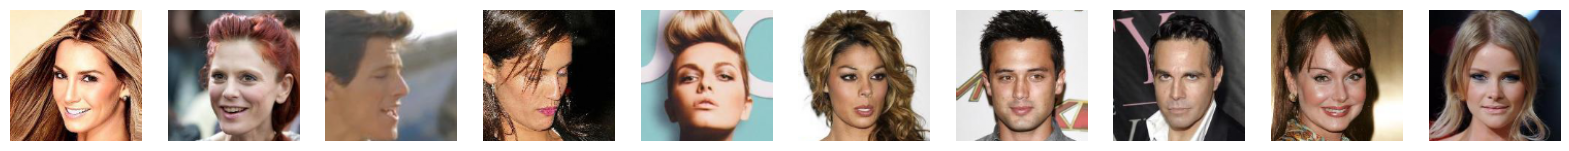

In [34]:
t.i = 0
plot_images_tensor(t.sample_images[t.i:t.i+12])

Reconstructed images:

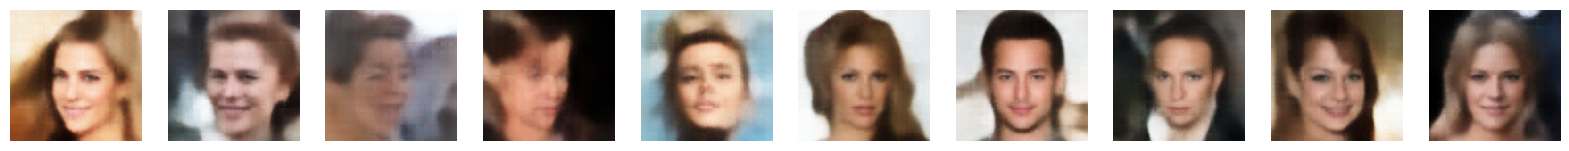

In [35]:
plot_images_tensor(t.model(t.sample_images[t.i : t.i+12])[0])

# Embedding Space

In [36]:
a = Object()
a.model = t.model

In [37]:
with torch.no_grad():
    a.emb = None
    image_count = 1024
    for images, _ in t.valid_loader:
        images = images.to(t.device)
        emb = a.model.encode(images)[0]
        emb = emb.detach().cpu().numpy()
        if a.emb is None:
            a.emb = emb
        else:
            a.emb = np.append(a.emb, emb, axis=0)
        image_count -= images.shape[0]
        del images
        if image_count <= 0:
            break
a.valid_emb = a.emb
torch.cuda.empty_cache()
a.valid_emb.shape

(1024, 200)

In [38]:
a.valid_emb[:, 4].shape

(1024,)

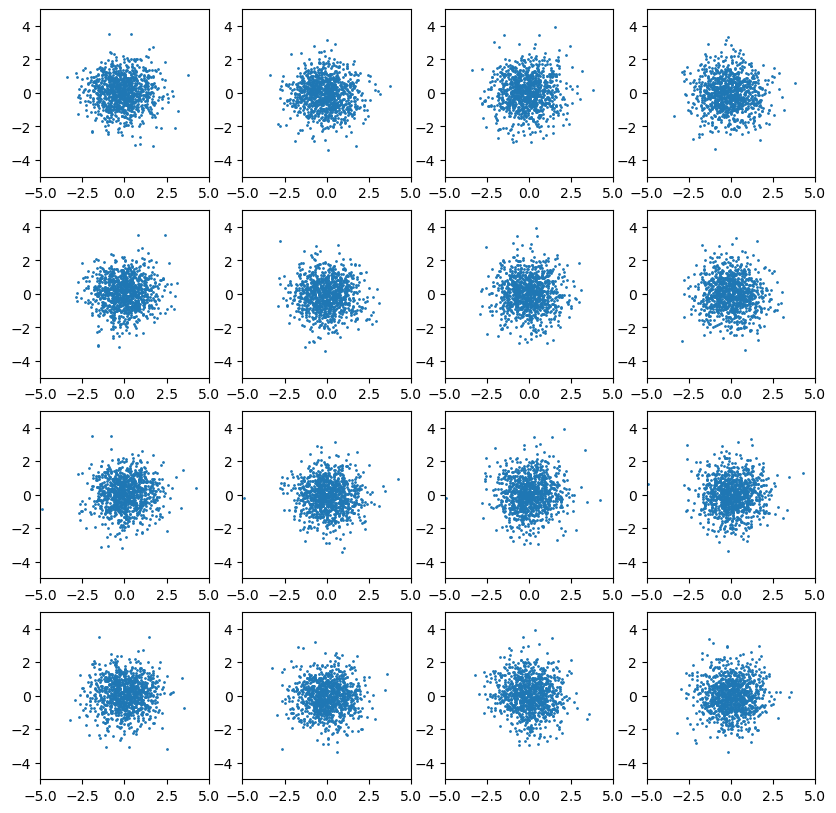

In [39]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i in range(4):
    for j in range(4):
        x = a.valid_emb[:, i]
        y = a.valid_emb[:, 10 + j]
        ax = fig.axes[i * 4 + j]
        ax.set_ylim(-5, 5)
        ax.set_xlim(-5, 5)
        ax.scatter(x, y, s=1)

# Sample Images from VAE

In [40]:
torch.randn(10, 5)

tensor([[ 0.8123, -0.1903,  0.1574,  0.8848,  0.1952],
        [-2.0655,  0.3989, -0.2372, -0.2876,  1.9701],
        [-0.0066,  0.6675,  2.6604,  0.6506, -3.0380],
        [ 0.2480,  0.6295, -0.4199, -1.3110,  0.4831],
        [-0.3370, -0.0664, -0.8828, -0.6701, -0.6434],
        [-0.6306, -0.7946,  0.0294, -1.7562, -0.8340],
        [ 0.7667, -1.8397, -0.8893, -0.2315, -0.2101],
        [-0.4130,  0.4442,  1.5332,  1.8764, -0.5761],
        [-1.0597, -1.2820,  0.2158, -0.6315,  0.3256],
        [ 0.2519, -0.6253,  1.6382, -1.8821,  0.2174]])

In [41]:
def sample_images_from_vae(model, emb_size, device, num_images):
    with torch.no_grad():
        rand_emb = torch.randn(num_images, emb_size).to(device)
        sampled_images = model.decoder(rand_emb)
        fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(10, 3), sharey=True)
        for ax, im in zip(axes, sampled_images):
            im_np = im.detach().cpu().numpy()
            im_np = np.transpose(im_np, (1, 2, 0))
            ax.imshow(im_np)

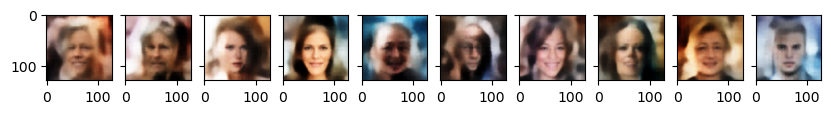

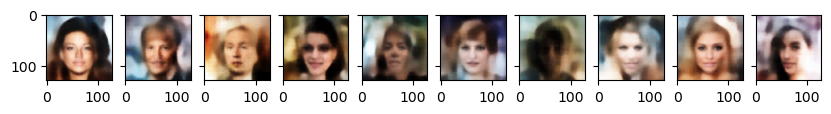

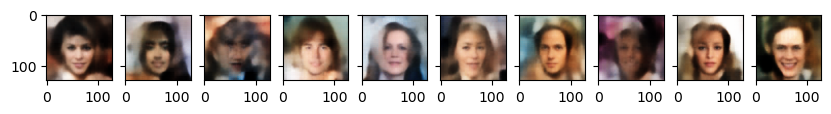

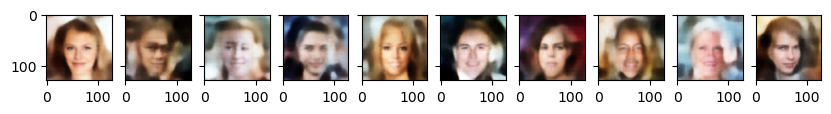

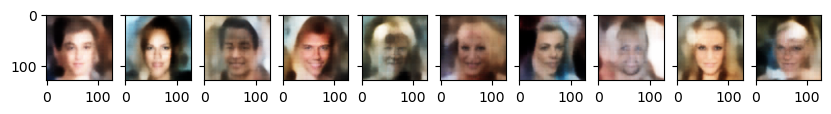

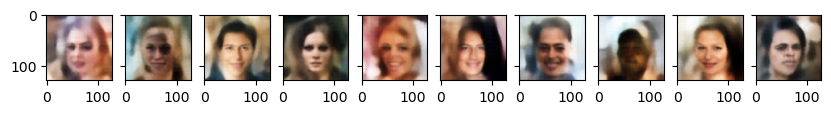

In [42]:
for row in range(6):
    sample_images_from_vae(t.model, 200, t.device, 10)
    plt.show()

# Latent Space Vector Algebra

1. Load 512 images with no smile.
   1. Get their embedddings.
   1. Calculate average.
1. Load 512 images with smile.
   1. Get their embedddings.
   1. Calculate average.
1. Calculate the difference between mean_smile - mean_no_smile. We'll get the "add smile" vector.


#### Q. How do we add a smile to an image?

In [43]:
a.train_loader = torch.utils.data.DataLoader(
    t.train_dataset,
    batch_size=64,
    num_workers=2,
    pin_memory=True,
    shuffle=True
)

## Calculate the "Smile" Vector

In [44]:
a.image_count = 512
a.smile_emb = torch.zeros(512, 3, 128, 128)
a.no_smile_emb = torch.zeros(512, 3, 128, 128)
a.images_no_smile = torch.zeros(512, 3, 128, 128)
a.images_smile = torch.zeros(512, 3, 128, 128)


a.count_smile = 0
a.count_no_smile = 0
a.iter = a.train_loader.__iter__();
a.classes = a.train_loader.dataset.smile_to_int

while a.count_smile < a.image_count or a.count_no_smile < a.image_count:
    images, labels = next(a.iter)
    for im, lbl in zip(images, labels):
        if lbl == a.classes['smile'] and a.count_smile < a.image_count:
            a.images_smile[a.count_smile, :, :, :] = im
            a.count_smile += 1
        elif a.count_no_smile < a.image_count:
            a.images_no_smile[a.count_no_smile, :, :, :] = im
            a.count_no_smile += 1

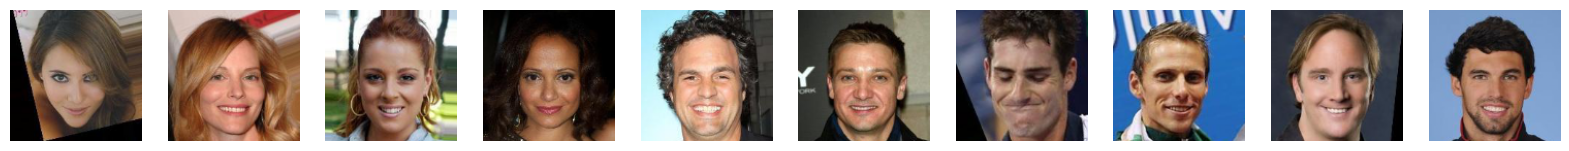

In [45]:
plot_images_tensor(a.images_smile[0: 10])

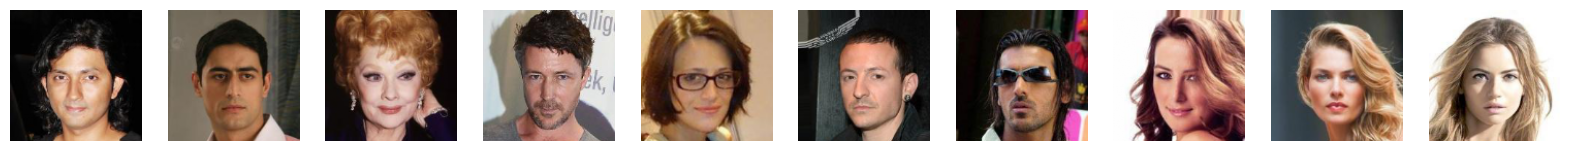

In [46]:
plot_images_tensor(a.images_no_smile[0: 10])

In [47]:
with torch.no_grad():
    a.smile_emb = a.model.encode(a.images_smile.to(t.device))[0]
    a.no_smile_emb = a.model.encode(a.images_no_smile.to(t.device))[0]
torch.cuda.empty_cache()

In [48]:
a.smile_vec = torch.mean(a.smile_emb, axis=0) - torch.mean(a.no_smile_emb)

In [49]:
a.smile_vec.shape, a.smile_vec

(torch.Size([200]),
 tensor([-1.5681e-01,  2.1372e-02,  1.4172e-01,  1.0480e-02, -2.6896e-02,
          1.9845e-02,  1.7608e-02, -3.5080e-03,  7.4997e-02, -1.3331e-01,
          6.8921e-02, -4.5600e-02,  2.2039e-01, -6.7959e-02,  7.4977e-02,
          2.4124e-01, -1.6012e-01,  1.2426e-02,  2.8394e-02, -1.0212e-02,
         -4.5254e-02,  5.8271e-02,  9.0452e-02,  1.8607e-02,  4.0400e-01,
          1.0438e-01,  8.0047e-02, -1.9716e-01, -2.2102e-02,  7.4415e-02,
          6.9947e-02,  9.5049e-02,  5.1631e-02, -1.7008e-01,  2.1589e-02,
          3.4151e-02, -7.3837e-03, -6.5325e-02,  7.4703e-03, -5.3810e-02,
          1.8616e-01, -3.1810e-02,  2.8276e-02, -4.2166e-02, -7.2402e-03,
          7.6044e-02,  3.6855e-02, -1.2569e-02,  1.3938e-01, -7.5172e-05,
         -1.4521e-01,  6.5859e-03,  1.6045e-02,  1.0544e-01,  1.5450e-01,
          2.2859e-02, -5.6223e-02,  2.1858e-02, -5.6382e-02, -4.2052e-02,
          5.0045e-02, -1.5001e-02,  9.0572e-02, -1.1340e-01,  7.9530e-03,
          7.9186e-

## Add a Smile

In [50]:
a.test_no_smile_images = a.images_no_smile[14:24]
with torch.no_grad():
    a.test_no_smile = a.model.encode(a.test_no_smile_images.to(t.device))[0]
torch.cuda.empty_cache()

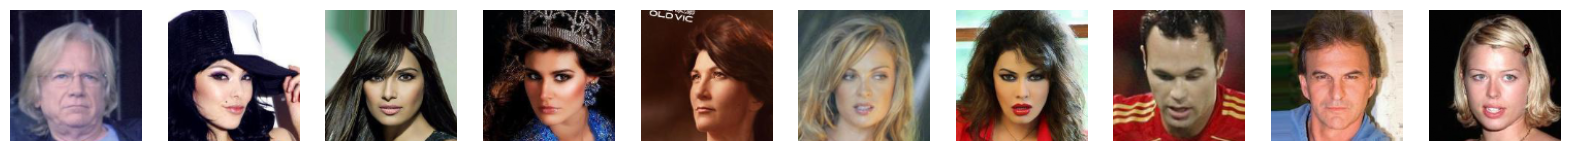

In [51]:
plot_images_tensor(a.test_no_smile_images)

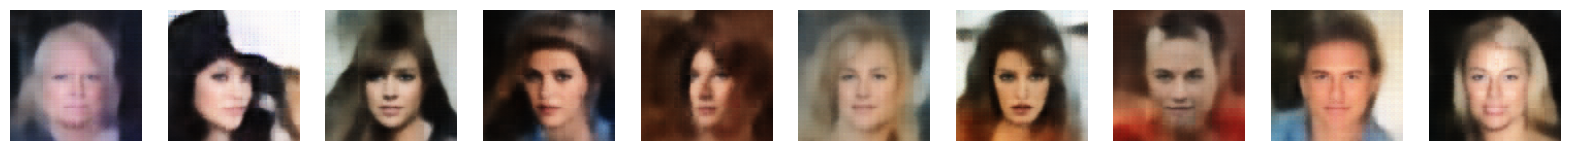

In [52]:
with torch.no_grad():
    a.test_smile_images = a.model.decoder(a.test_no_smile)
torch.cuda.empty_cache()
plot_images_tensor(a.test_smile_images)

In [53]:
a.test_smile = a.test_no_smile  + 1.5 * a.smile_vec
a.test_smile.shape

torch.Size([10, 200])

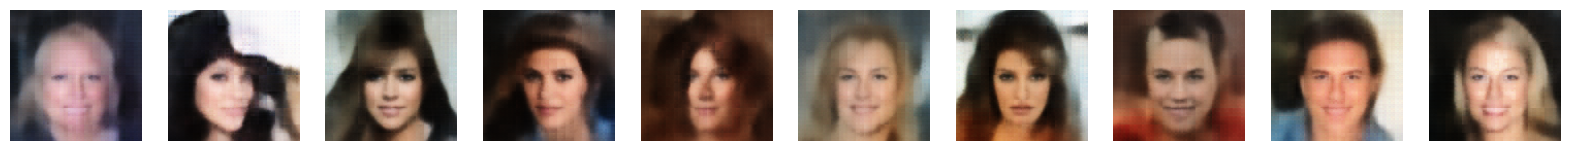

In [54]:
with torch.no_grad():
    a.test_smile_images = a.model.decoder(a.test_smile)
torch.cuda.empty_cache()
plot_images_tensor(a.test_smile_images)